In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove-embeddings/glove.6B.200d.txt
/kaggle/input/glove-embeddings/glove.6B.50d.txt
/kaggle/input/glove-embeddings/glove.6B.300d.txt
/kaggle/input/glove-embeddings/glove.6B.100d.txt
/kaggle/input/yelp-chi-balanced-generated-reviews/yelp_chi_with_generated_reviews.csv


In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/word

In [3]:

def set_seed(seed: int = 42):
    import random
    """
    Фиксирует seed для всех источников случайности.

    Args:
        seed (int): Значение seed.
    """
    # Python's random module
    random.seed(seed)
    
    # NumPy
    np.random.seed(seed)
    
    # PyTorch
    torch.manual_seed(seed)
    
    # Если используется CUDA (GPU)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # Для multi-GPU.

In [4]:
set_seed(42)

In [5]:
df = pd.read_csv('/kaggle/input/yelp-chi-balanced-generated-reviews/yelp_chi_with_generated_reviews.csv')
df

,label,review
0,1,dear calo thank always consistent really nice ...
1,1,get wrong everything good tasty feel like put ...
2,1,lovely place great atmosphere wonderful staff ...
3,0,sushi night highly recommend new place downtow...
4,0,highly recommend italian restaurant pasta dish...
...,...,...
93949,1,place awesome first love coffee want great cup...
93950,1,boom boom boom let us go back room eat night m...
93951,1,repeating everyone else saidit amazing went th...
93952,1,review good pork sandwich lots flavor deliciou...


In [6]:
reviews_texts = df[['review', 'label']]
reviews_texts.isna().sum()

review    1
label     0
dtype: int64

# Базовая предобработка текстов

In [7]:
! pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 7.5 MB/s eta 0:00:00


In [8]:
import re
import contractions

stop_words = set(stopwords.words('english'))
def preprocess_review(text):
    text = contractions.fix(text)
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\d'\s]", '', text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

text = "This is an example for wifes test 145 13 we're don't"
preprocess_review(text)

'example wifes test 145 13'

In [9]:
# reviews_texts['review'] = reviews_texts['review'].apply(preprocess_review)

In [10]:
# reviews_texts['review'].head(10)

In [11]:
# for r in reviews_texts['review']:
#     splitted_r = r.split()
#     short_reviews_list = []
#     if len(splitted_r)<300:
#         short_review = ' '.join(splitted_r)
#         short_reviews_list.append(short_review)

# print(len(short_reviews_list))
# print(len(short_reviews_list[0].split()))


# Torch классы и функции

In [12]:
import matplotlib.pyplot as plt

In [13]:
def load_embedding_from_file(path_to_embedding):
    embeddings = {}
    with open(path_to_embedding, 'r', encoding='utf-8') as f:
        for line in f:
            splitted_line = line.strip().split()
            word = splitted_line[0]
            vector = np.array(splitted_line[1:])
            # print(word, vector, vector.shape)
            embeddings[word] = vector
    return embeddings
    

In [14]:
from collections import Counter

def build_vocabulary_and_embeddings(reviews, embeddings:dict, embedding_dim:int):
    vocabulary = {
        'PAD' : 0,
        'UKN' : 1,
    }

    counter = Counter()
    not_in_embeddings = []
    for review in reviews:
        try:
            counter.update(review.strip().split())
        except AttributeError as e:
            print(review)
    # print(counter.most_common())

    # Построение словаря. most_common - для аггрегации слов
    for word, _ in counter.most_common():
        if word in embeddings:
            vocabulary[word] = len(vocabulary)
        else:
            not_in_embeddings.append(word)
    print('Кол-во слов, которых нет в эмбеддинге:', len(not_in_embeddings))

    embedding_matrix = np.zeros((len(vocabulary), embedding_dim))    

    for word, index in vocabulary.items():
        if word in embeddings:
            embedding_matrix[index] = embeddings[word]
        elif word == 'UKN':
            embedding_matrix[index] = np.random.normal(scale=0.6, size=(embedding_dim,))

    return vocabulary, embedding_matrix
    
# vocabulary2, embedding_matrix2 = build_vocabulary_and_embeddings(['very good', 'very nice', 'super good'], 
                                                               # glove_dict, 
                                                               # 300)
# print(vocabulary2)
# print(embedding_matrix2[1])

In [15]:
class ReviewsDataset(Dataset):
    def __init__(self, reviews, labels, vocabulary, embedding_matrix, max_len):
        self.reviews = reviews
        self.labels = labels
        self.vocabulary = vocabulary
        self.embedding_matrix = embedding_matrix
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, index):
        review = self.reviews[index]
        label = self.labels[index]
        # работа с токенами в отзыве
        tokens = review.split()[:self.max_len] # берем определенное количество токенов
        inds = [self.vocabulary.get(tok, self.vocabulary['UKN']) for tok in tokens] # вычисляем их индексы
        # заполнение нулями
        padding_length = self.max_len - len(inds)
        inds += [self.vocabulary['PAD']] * padding_length
        return torch.tensor(inds), torch.tensor(label)

In [16]:
import numpy as np
import torch
class Early_stopping:
    def __init__(self, patience=3, delta=0.0, save_path='model_weights.pth'):
        self.patience = patience
        self.delta = delta
        self.save_path = save_path
        self.best_loss = np.inf
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            print(f"Best loss: {self.best_loss}")
            self.counter = 0
            torch.save(model.state_dict(), self.save_path) # сохраняем веса наилучшей модели
            model.load_state_dict(torch.load(self.save_path, weights_only=True))
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                print("Early stopping triggered! Best model weights saved.")

In [17]:
def unfreeze_embeddings(model):
    for param in model.embedding.parameters():
         param.requires_grad = True
    print('Embeddings unfreeze')

In [18]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,classification_report, confusion_matrix

def compute_metrics(labels, preds):
    # Преобразуем предсказания в вероятности (если нужно)
    # print(preds)
    # preds = [int(p) for p in preds]
    # preds_classes = np.round(probs).astype(int)

    if np.any(np.isnan(preds)):
        print("Warning: NaN values found in predictions!")
        preds = np.nan_to_num(preds)  # Заменяем NaN на 0
    preds_classes = np.round(preds).astype(int)
    
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, zero_division=0)
    recall = recall_score(labels, preds, zero_division=0)
    f1 = f1_score(labels, preds, zero_division=0)
    auc = roc_auc_score(labels, preds) 
    # if len(np.unique(labels)) > 1 else 0.5  # AUC требует обоих классов

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'F1': f1,
        'AUC': auc
    }

def show_metrics(y_true, y_pred, title):
    print(f'''
                {title}
==========================================
 auc: {roc_auc_score(y_true, y_pred)}             
==========================================
 report:                                
{classification_report(y_true, y_pred)}
==========================================

    ''')    

def show_confusion_matrix(y_true, y_pred, title_string):
    conf = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,8))
    plt.title(title_string)
    sns.heatmap(conf, fmt='d', annot=True)
    plt.savefig(title_string+'_confusion_matrix.png')
    plt.show()

In [19]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, device, num_epochs, early_stopping=None):
    # сохраняем историю во время обучения
    history = {
        'train_loss':[],
        'train_accuracy' :[],
        'train_precision':[],
        'train_recall':[],
        'train_F1':[],
        'train_AUC': [],
        'val_loss':[],
        
        'val_accuracy' :[],
        'val_precision':[],
        'val_recall':[],
        'val_F1':[],
        'val_AUC':[]
    }   

    grad_logs = {}
    flag_freeze = False
    
    for epoch in tqdm(range(num_epochs), desc="Epochs", position=0): 
        print(f'\nEpoch {epoch + 1}/{num_epochs}')
        print('-' * 20)

        # Режим обучения
        model.train()
        train_losses = []
        train_preds = []
        train_labels = []
        print('-----Обучение-----')
        for inputs, labels in train_loader:
        # with torch.autograd.detect_anomaly():
            inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
            optimizer.zero_grad() # обнуляем градиенты для текущего батча
            outputs = model(inputs) # вычисляем выход модели

            # if (epoch == 12) and not(flag_freeze) :
            #     unfreeze_embeddings(model)
            #     flag_freeze = True
            
            
            if torch.any(torch.isnan(outputs)):
                print("NAN значения среди outputs!")
                print(outputs[:4])
                return history, grad_logs
            
            loss = criterion(outputs, labels) # вычисляем loss для батча
            if torch.isnan(loss):
                print("NaN в лоссе!")
                print(f'''
                -----------------------
                -----------------------
                loss: {loss}
                -----------------------
                -----------------------
                inputs: {inputs}
                -----------------------
                -----------------------
                outputs: {outputs}
                -----------------------
                -----------------------
                
                ''')
                return history, grad_logs
            train_losses.append(loss.item()) 
            loss.backward()
                
            # вывод градиента, проверка на взрыв/затухание
            for name, param in model.named_parameters():
                if param.grad is not None:
                    if name not in grad_logs.keys():
                        grad_logs[name] = []    
                    grad_logs[name].append(param.grad.norm().item())
                    
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
            
            optimizer.step()

            preds = torch.sigmoid(outputs).round().detach().cpu().numpy()
            if np.any(np.isnan(preds[:4])):
                print("NAN значения среди preds!")
                print(preds)
                return history, grad_logs
            labels = labels.detach().cpu().numpy()
            train_preds.extend(preds.flatten())
            train_labels.extend(labels.flatten())
        # считаем показатели после эпохи
        train_loss = sum(train_losses) / len(train_losses) # среднее на эпохе
        train_metrics = compute_metrics(train_labels, train_preds) # метрики на эпохе
        # сохранем историю после эпохи
        for name, value in train_metrics.items():
            history[f"train_{name}"].append(value)
        history['train_loss'].append(train_loss)
        #======#
        
        # режим валидации
        model.eval()
        val_losses = []
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_losses.append(loss.item())

                preds = torch.sigmoid(outputs).round().detach().cpu().numpy()
                labels = labels.detach().cpu().numpy()

                val_preds.extend(preds)
                val_labels.extend(labels)
            
            val_loss = sum(val_losses) / len(val_losses)
            val_metrics = compute_metrics(val_labels, val_preds)
            for metric_name, metric_value in val_metrics.items():
                history[f'val_{metric_name}'].append(metric_value)
            history['val_loss'].append(val_loss)
         # Вывод метрик
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_metrics["accuracy"]:.4f} | ',
              f'Train Precision: {train_metrics["precision"]:.4f} | Train Recall: {train_metrics["recall"]:.4f} | ',
              f'Train F1: {train_metrics["F1"]:.4f} | Train AUC: {train_metrics["AUC"]:.4f}')
        
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_metrics["accuracy"]:.4f} | ',
              f'Val Precision: {val_metrics["precision"]:.4f} | Val Recall: {val_metrics["recall"]:.4f} | ',
              f'Val F1: {val_metrics["F1"]:.4f} | Val AUC: {val_metrics["AUC"]:.4f}')

        if early_stopping is not None:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print(f'Stop after {epoch} epochs')
                return history, grad_logs
        
    return history, grad_logs

In [20]:
def plot_metrics(history, model_name):
    """
    Визуализирует метрики из словаря history.

    :param history: Словарь, содержащий метрики обучения и валидации.
    """
    # Проверяем, есть ли данные для визуализации
    if not history:
        print("Словарь history пуст.")
        return

    # Извлекаем метрики из history
    metrics = ['loss', 'accuracy', 'precision', 'recall', 'F1', 'AUC']
    train_metrics = [f'train_{metric}' for metric in metrics]
    val_metrics = [f'val_{metric}' for metric in metrics]

    # Создаём графики для каждой метрики
    plt.figure(figsize=(15, 10))
    plt.title(f"Процесс обучения {model_name}")
    for i, (metric, val_metric) in enumerate(zip(train_metrics, val_metrics)):
        plt.subplot(2, 3, i + 1)  # 2 строки, 3 столбца, i+1 — позиция графика
        if metric in history:
            plt.plot(history[metric], label=f'Обучение')
        if val_metric in history:
            plt.plot(history[val_metric], label=f'Валидация')

        plt.title(metric.capitalize()[6:])
        plt.xlabel('Эпохи')
        plt.ylabel("Значения метрики")
        plt.legend()
    plt.savefig(f'Процесс обучения {model_name}')
    plt.tight_layout()
    plt.show()

In [21]:
def eval_model(model, test_loader, criterion, device):
    model.eval()
    losses = []
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating(test)"):
            inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            preds = torch.sigmoid(outputs).round().detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            all_preds.extend(preds.flatten())
            all_labels.extend(labels.flatten())

    metrics = compute_metrics(all_labels, all_preds)
    metrics['loss'] = sum(losses) / len(losses)
    return sum(losses) / len(losses), metrics, all_labels, all_preds
            

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_metrics_eval(history_dict, model_name):
    keys = list(history_dict.keys())
    values = list(map(lambda x: round(x, 4), list(history_dict.values())))
    
    print(keys)
    print(values)
    
    plt.figure(figsize=(12,8))
    ax = sns.barplot(x=keys, y=values)
    plt.xlabel('Метрики')
    plt.ylabel('Значения метрик')
    plt.title(f'Метрики {model_name} на тестовой выборке')
    for p, l in zip(ax.patches, values):
        ax.text(p.get_x() + p.get_width() / 2, p.get_height(), l, ha = 'center', va = 'bottom')   
    plt.legend()

    plt.savefig(f'Метрики {model_name} на тестовой выборке.png')
    plt.tight_layout()
    plt.show()

# Предобработка

In [23]:
reviews_texts.head(4)

,review,label
0,dear calo thank always consistent really nice ...,1
1,get wrong everything good tasty feel like put ...,1
2,lovely place great atmosphere wonderful staff ...,1
3,sushi night highly recommend new place downtow...,0


In [24]:
reviews_texts['label'] = reviews_texts['label'].replace(-1, 0)
reviews_texts.tail(4)


,review,label
93950,boom boom boom let us go back room eat night m...,1
93951,repeating everyone else saidit amazing went th...,1
93952,review good pork sandwich lots flavor deliciou...,1
93953,place great food decent prices great getaway s...,1


In [25]:
reviews_texts[reviews_texts['review'].isna()]

,review,label
16961,NaN,0


In [26]:
reviews_texts = reviews_texts.dropna()

In [27]:
reviews_texts.reset_index(drop=True, inplace=True)

In [28]:
glove_path = '/kaggle/input/glove-embeddings/glove.6B.300d.txt'
glove_dict = load_embedding_from_file(glove_path)


In [29]:
vocabulary, embedding_matrix = build_vocabulary_and_embeddings(reviews_texts['review'], embeddings=glove_dict, embedding_dim=300)


Кол-во слов, которых нет в эмбеддинге: 56337


In [30]:
print(len(vocabulary))
print(embedding_matrix.shape)
# ukn = vocabulary['UKN']
# print(ukn)
# print(embedding_matrix[ukn])

print(vocabulary.get('qqqqq', vocabulary['UKN']))


40085
(40085, 300)
1


In [31]:
pad = vocabulary['PAD']
print(pad)
print(embedding_matrix[pad])
type(embedding_matrix)

0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


numpy.ndarray

In [32]:
vocabulary_keys = list(vocabulary.keys())
not_in_glove = []
for key in vocabulary_keys:
    if key not in glove_dict.keys():
        not_in_glove.append(key)
print(not_in_glove)
    

['PAD', 'UKN']


In [33]:
reviews_texts['review']

0        dear calo thank always consistent really nice ...
1        get wrong everything good tasty feel like put ...
2        lovely place great atmosphere wonderful staff ...
3        sushi night highly recommend new place downtow...
4        highly recommend italian restaurant pasta dish...
                               ...                        
93948    place awesome first love coffee want great cup...
93949    boom boom boom let us go back room eat night m...
93950    repeating everyone else saidit amazing went th...
93951    review good pork sandwich lots flavor deliciou...
93952    place great food decent prices great getaway s...
Name: review, Length: 93953, dtype: object

In [34]:
full_dataset = ReviewsDataset(reviews = reviews_texts['review'], 
                             labels = reviews_texts['label'],
                             vocabulary = vocabulary,
                             embedding_matrix = embedding_matrix,
                             max_len = 256
                            )

In [35]:
from torch.utils.data import random_split
generator = torch.Generator().manual_seed(42)
train_dataset, valid_dataset, test_dataset = random_split(full_dataset, [0.75, 0.05, 0.2], generator=generator)

print(f"""
Размер тренировочного набора: {len(train_dataset)}, 
Размер валидационного набора: {len(valid_dataset)}, 
Размер тестового набора: {len(test_dataset)}, 
"""
)


Размер тренировочного набора: 70465, 
Размер валидационного набора: 4698, 
Размер тестового набора: 18790, 



In [36]:
# cnt_fake, cnt_true = 0, 0
# for _, labels in train_loader:
#         cnt_fake += (labels==0).sum()
#         cnt_true += (labels==1).sum()
    
# print('фейковые: ', cnt_fake, 'настоящие: ', cnt_true)

In [37]:
# cnt_fake, cnt_true = 0, 0
# for _, labels in valid_loader:
#         cnt_fake += (labels==0).sum()
#         cnt_true += (labels==1).sum()
    
# print('фейковые: ', cnt_fake, 'настоящие: ', cnt_true)

In [38]:
# cnt_fake, cnt_true = 0, 0
# for _, labels in test_loader:
#         cnt_fake += (labels==0).sum()
#         cnt_true += (labels==1).sum()
    
# print('фейковые: ', cnt_fake, 'настоящие: ', cnt_true)

In [39]:
train_loader = DataLoader(train_dataset, batch_size = 256, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 256, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 32)


# Модели

In [40]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F

In [41]:
def init_weights(m):
    if isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight_ih' in name:  # Веса входного слоя
                init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:  # Веса рекуррентного слоя
                init.orthogonal_(param.data)  
            elif 'bias' in name:  # Смещения (bias)
                param.data.fill_(0)

    elif isinstance(m, nn.Linear):  # Полносвязный слой
        init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            m.bias.data.fill_(0)

# Simple LSTM

In [42]:
#Гиперпараметры
embedding_dim = 300
hidden_dim = 256
output_dim = 1
lr = 0.005
num_epochs = 100
dropout_rate = 0.25
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)



cuda


In [43]:
simple_lstm_model = nn.Sequential(
    nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32)),
    nn.Dropout(dropout_rate),
    nn.LSTM(input_size=embedding_matrix.shape[1], hidden_size=hidden_dim, batch_first=True),
    nn.Linear(hidden_dim, output_dim)
)
print(simple_lstm_model)

Sequential(
  (0): Embedding(40085, 300)
  (1): Dropout(p=0.25, inplace=False)
  (2): LSTM(300, 256, batch_first=True)
  (3): Linear(in_features=256, out_features=1, bias=True)
)


## Обучение Simple LSTM

In [44]:
class LSTM_model(nn.Module):
    def __init__(self, vocab_size, embedding_matrix, embedding_dim, hidden_dim, output_dim, dropout_rate):
        super(LSTM_model, self).__init__()
        embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
        self.embedding.weight.requires_grad = True # заморозка весов для эмбеддинга
        self.embedding_dropout = nn.Dropout(dropout_rate)
        self.lstm = nn.LSTM(
                            input_size=embedding_matrix.shape[1],
                            num_layers=1,
                            hidden_size=hidden_dim,
                            batch_first=True,
                           )
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.embedding_dropout(embedded)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out[:, -1, :]  # Берем последний таймстеп
        output = self.fc2(lstm_out)
        return output
        

In [45]:
simple_lstm_model = LSTM_model(vocab_size=len(vocabulary),
                              embedding_matrix=embedding_matrix, 
                              embedding_dim=embedding_matrix.shape[1],
                              hidden_dim=hidden_dim, 
                              output_dim=output_dim,
                              dropout_rate=dropout_rate)

In [46]:
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.AdamW(simple_lstm_model.parameters(), lr=lr, weight_decay=0.0001)
early_stopping = Early_stopping(patience=6, delta=0.001, save_path='simple_lstm_model.pth')
simple_lstm_model.to(device)

LSTM_model(
  (embedding): Embedding(40085, 300)
  (embedding_dropout): Dropout(p=0.25, inplace=False)
  (lstm): LSTM(300, 256, batch_first=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)

In [47]:
history, _ = train_model(model=simple_lstm_model, 
                        train_loader=train_loader,
                        valid_loader=valid_loader, 
                        criterion=criterion, 
                        optimizer=optimizer, 
                        device=device, 
                        num_epochs=num_epochs, 
                        early_stopping=early_stopping
                        )

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1/100
--------------------
-----Обучение-----


Epochs:   1%|          | 1/100 [00:28<46:56, 28.45s/it]

Train Loss: 0.5191 | Train Acc: 0.7306 |  Train Precision: 0.6992 | Train Recall: 0.9240 |  Train F1: 0.7960 | Train AUC: 0.6997
Val Loss: 0.3606 | Val Acc: 0.8580 |  Val Precision: 0.8145 | Val Recall: 0.9724 |  Val F1: 0.8864 | Val AUC: 0.8395
Best loss: 0.3606054578956805

Epoch 2/100
--------------------
-----Обучение-----


Epochs:   2%|▏         | 2/100 [00:56<46:12, 28.29s/it]

Train Loss: 0.3248 | Train Acc: 0.8709 |  Train Precision: 0.8429 | Train Recall: 0.9502 |  Train F1: 0.8933 | Train AUC: 0.8582
Val Loss: 0.3144 | Val Acc: 0.8738 |  Val Precision: 0.8432 | Val Recall: 0.9563 |  Val F1: 0.8962 | Val AUC: 0.8604
Best loss: 0.314377309460389


Epochs:   3%|▎         | 3/100 [01:25<45:53, 28.39s/it]


Epoch 3/100
--------------------
-----Обучение-----
Train Loss: 0.2804 | Train Acc: 0.8856 |  Train Precision: 0.8541 | Train Recall: 0.9635 |  Train F1: 0.9055 | Train AUC: 0.8731
Val Loss: 0.3181 | Val Acc: 0.8736 |  Val Precision: 0.8445 | Val Recall: 0.9537 |  Val F1: 0.8958 | Val AUC: 0.8606

Epoch 4/100
--------------------
-----Обучение-----


Epochs:   4%|▍         | 4/100 [01:54<45:52, 28.67s/it]

Train Loss: 0.2437 | Train Acc: 0.9003 |  Train Precision: 0.8789 | Train Recall: 0.9565 |  Train F1: 0.9161 | Train AUC: 0.8913
Val Loss: 0.3107 | Val Acc: 0.8768 |  Val Precision: 0.8497 | Val Recall: 0.9522 |  Val F1: 0.8980 | Val AUC: 0.8645
Best loss: 0.31073245719859477

Epoch 5/100
--------------------
-----Обучение-----


Epochs:   5%|▌         | 5/100 [02:23<45:57, 29.02s/it]

Train Loss: 0.2135 | Train Acc: 0.9138 |  Train Precision: 0.8991 | Train Recall: 0.9557 |  Train F1: 0.9266 | Train AUC: 0.9071
Val Loss: 0.3269 | Val Acc: 0.8650 |  Val Precision: 0.8713 | Val Recall: 0.8954 |  Val F1: 0.8832 | Val AUC: 0.8601

Epoch 6/100
--------------------
-----Обучение-----


Epochs:   6%|▌         | 6/100 [02:54<46:19, 29.57s/it]

Train Loss: 0.1889 | Train Acc: 0.9249 |  Train Precision: 0.9139 | Train Recall: 0.9583 |  Train F1: 0.9356 | Train AUC: 0.9196
Val Loss: 0.3463 | Val Acc: 0.8672 |  Val Precision: 0.8611 | Val Recall: 0.9145 |  Val F1: 0.8870 | Val AUC: 0.8595

Epoch 7/100
--------------------
-----Обучение-----


Epochs:   7%|▋         | 7/100 [03:24<46:01, 29.69s/it]

Train Loss: 0.1687 | Train Acc: 0.9342 |  Train Precision: 0.9241 | Train Recall: 0.9634 |  Train F1: 0.9433 | Train AUC: 0.9295
Val Loss: 0.3508 | Val Acc: 0.8785 |  Val Precision: 0.8669 | Val Recall: 0.9294 |  Val F1: 0.8971 | Val AUC: 0.8702

Epoch 8/100
--------------------
-----Обучение-----


Epochs:   8%|▊         | 8/100 [03:54<45:41, 29.80s/it]

Train Loss: 0.1485 | Train Acc: 0.9425 |  Train Precision: 0.9339 | Train Recall: 0.9675 |  Train F1: 0.9504 | Train AUC: 0.9385
Val Loss: 0.3691 | Val Acc: 0.8763 |  Val Precision: 0.8735 | Val Recall: 0.9156 |  Val F1: 0.8940 | Val AUC: 0.8700

Epoch 9/100
--------------------
-----Обучение-----


Epochs:   9%|▉         | 9/100 [04:24<45:21, 29.90s/it]

Train Loss: 0.1365 | Train Acc: 0.9479 |  Train Precision: 0.9397 | Train Recall: 0.9708 |  Train F1: 0.9550 | Train AUC: 0.9443
Val Loss: 0.3554 | Val Acc: 0.8751 |  Val Precision: 0.8703 | Val Recall: 0.9174 |  Val F1: 0.8933 | Val AUC: 0.8682

Epoch 10/100
--------------------
-----Обучение-----


Epochs:   9%|▉         | 9/100 [04:54<49:39, 32.74s/it]

Train Loss: 0.1229 | Train Acc: 0.9528 |  Train Precision: 0.9462 | Train Recall: 0.9724 |  Train F1: 0.9591 | Train AUC: 0.9497
Val Loss: 0.4185 | Val Acc: 0.8653 |  Val Precision: 0.8698 | Val Recall: 0.8980 |  Val F1: 0.8837 | Val AUC: 0.8599
Early stopping triggered! Best model weights saved.
Stop after 9 epochs


<ipython-input-20-3aeef0aace76>:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, i + 1)  # 2 строки, 3 столбца, i+1 — позиция графика


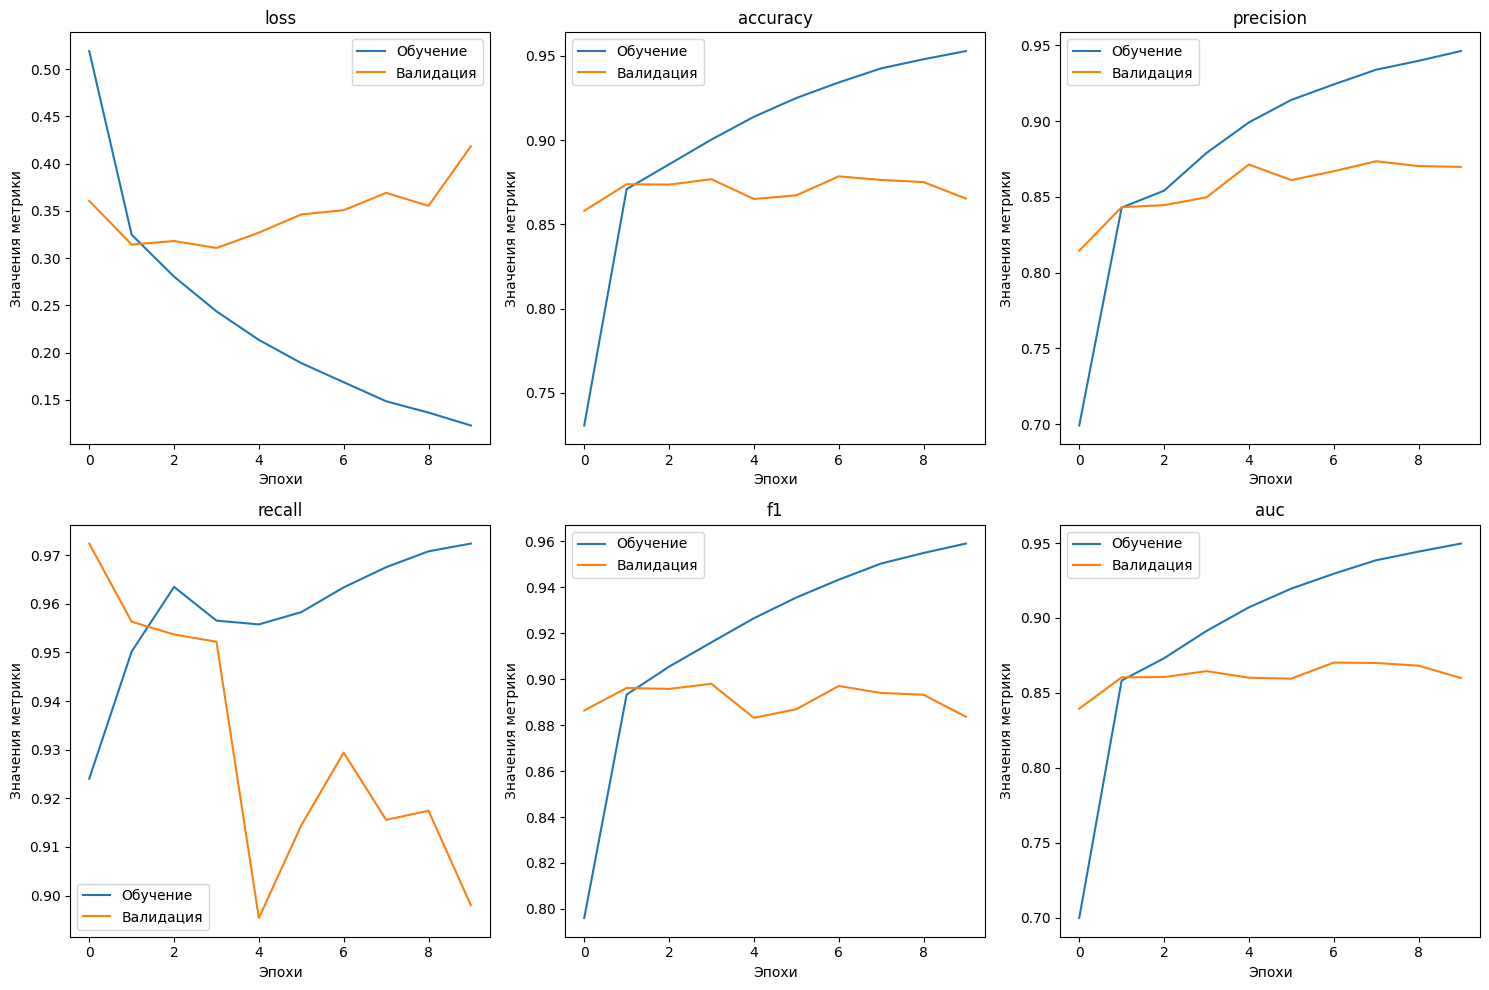

In [48]:
plot_metrics(history, model_name = 'LSTM')

In [49]:
simple_lstm_model.load_state_dict(torch.load('simple_lstm_model.pth', weights_only=True))

<All keys matched successfully>

## Оценка Simple LSTM

In [50]:
_, metrics, labels, preds = eval_model(simple_lstm_model, test_loader, criterion, device)

Evaluating(test): 100%|██████████| 588/588 [00:04<00:00, 122.10it/s]


In [51]:
show_metrics(labels, preds, 'LSTM')


                LSTM
 auc: 0.8679849026966922             
 report:                                
              precision    recall  f1-score   support

         0.0       0.94      0.78      0.85      8187
         1.0       0.85      0.96      0.90     10603

    accuracy                           0.88     18790
   macro avg       0.89      0.87      0.87     18790
weighted avg       0.89      0.88      0.88     18790


    


['accuracy', 'precision', 'recall', 'F1', 'AUC', 'loss']
[0.8798, 0.8473, 0.9601, 0.9002, 0.868, 0.3054]


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


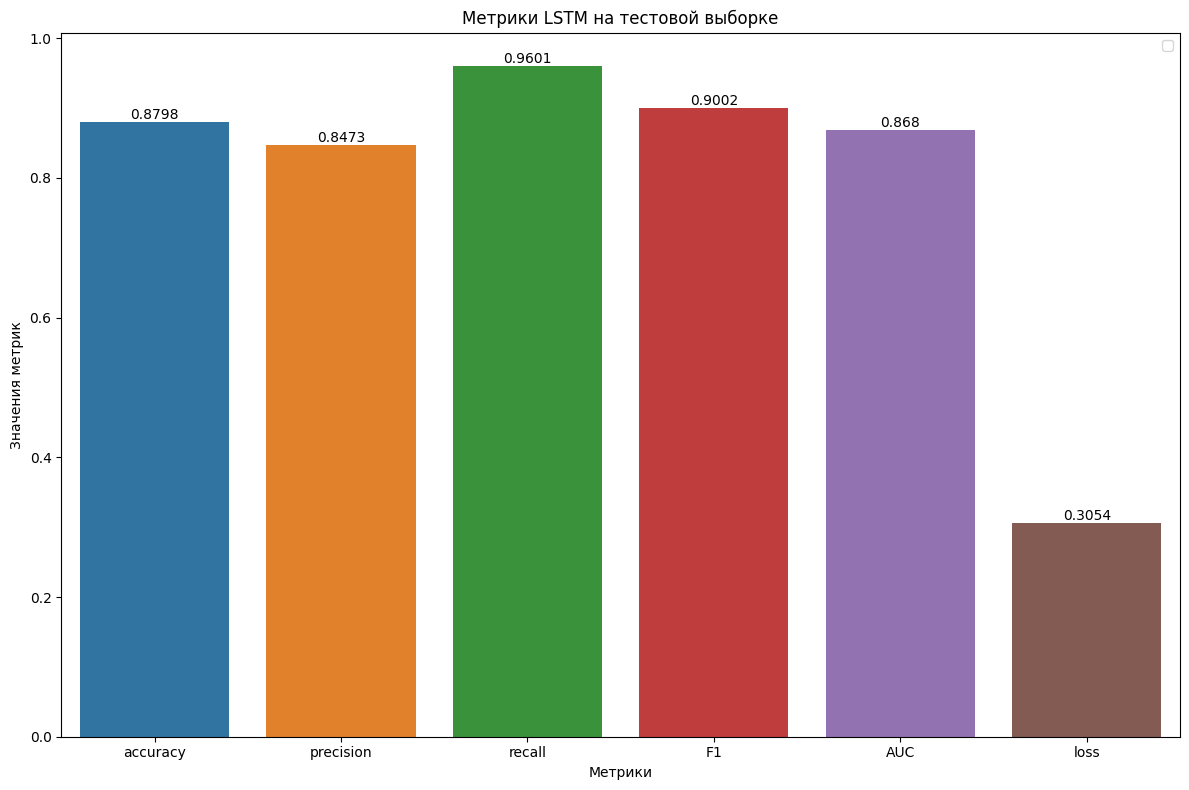

In [52]:
plot_metrics_eval(metrics, 'LSTM')

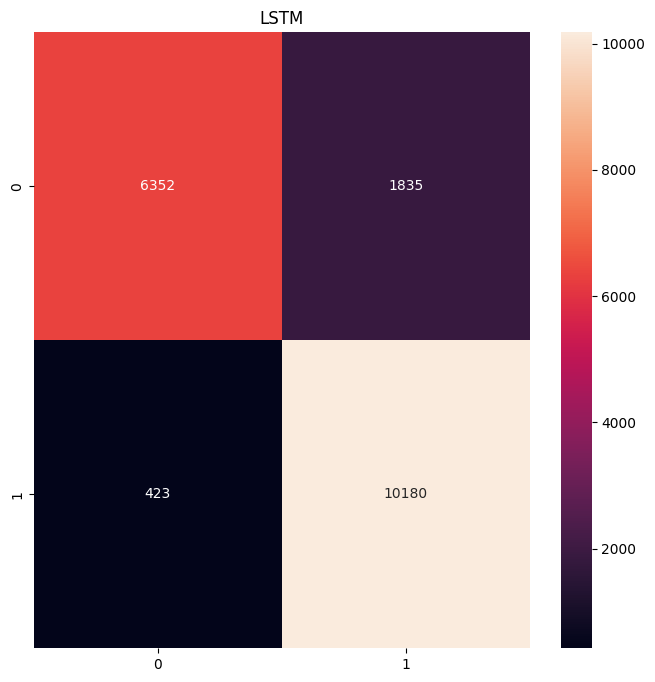

In [53]:
show_confusion_matrix(labels, preds, 'LSTM')

# Simple GRU

In [54]:
class GRU_model(nn.Module):
    def __init__(self, vocab_size, embedding_matrix, embedding_dim, hidden_dim, output_dim, dropout_rate):
        super(GRU_model, self).__init__()
        embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
        self.embedding.weight.requires_grad = True # заморозка весов для эмбеддинга
        self.embedding_dropout = nn.Dropout(dropout_rate)
        self.gru = nn.GRU(
                            input_size=embedding_matrix.shape[1],
                            num_layers=1,
                            hidden_size=hidden_dim,
                            batch_first=True,
                           ).to(device)
        # self.fc1 = nn.Linear(hidden_dim, 128).to(device)
        # self.relu = nn.ReLU().to(device)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.embedding_dropout(embedded)
        gru_out, _ = self.gru(embedded)
        gru_out = gru_out[:, -1, :]  # Берем последний таймстеп
        # fc1_out = self.fc1(lstm_out)
        # fc1_out = self.relu(fc1_out)
        output = self.fc2(gru_out)
        return output
        

## Обучение Simple GRU

In [55]:
#Гиперпараметры
embedding_dim = 300
hidden_dim = 256
output_dim = 1
lr = 0.001
num_epochs = 100
dropout_rate = 0.25
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)



cuda


In [56]:
embedding_dim

300

In [57]:

simple_gru_model = GRU_model(vocab_size=len(vocabulary),
                              embedding_matrix=embedding_matrix, 
                              embedding_dim=embedding_matrix.shape[1],
                              hidden_dim=hidden_dim, 
                              output_dim=output_dim,
                              dropout_rate=dropout_rate)

In [58]:
print(simple_gru_model)


GRU_model(
  (embedding): Embedding(40085, 300)
  (embedding_dropout): Dropout(p=0.25, inplace=False)
  (gru): GRU(300, 256, batch_first=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)


In [59]:
simple_gru_model.to(device)
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.AdamW(simple_gru_model.parameters(), lr=lr, weight_decay=0.0001)
early_stopping = Early_stopping(patience=5, delta=0.0001, save_path = "simple_GRU.pth")


In [60]:
history, grad_logs = train_model(simple_gru_model, train_loader, valid_loader, criterion, optimizer, device, num_epochs, early_stopping)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1/100
--------------------
-----Обучение-----


Epochs:   1%|          | 1/100 [00:25<41:36, 25.22s/it]

Train Loss: 0.6236 | Train Acc: 0.6334 |  Train Precision: 0.6123 | Train Recall: 0.9697 |  Train F1: 0.7506 | Train AUC: 0.5797
Val Loss: 0.3921 | Val Acc: 0.8361 |  Val Precision: 0.8007 | Val Recall: 0.9484 |  Val F1: 0.8683 | Val AUC: 0.8179
Best loss: 0.39210515116390426

Epoch 2/100
--------------------
-----Обучение-----


Epochs:   2%|▏         | 2/100 [00:50<41:19, 25.30s/it]

Train Loss: 0.3340 | Train Acc: 0.8638 |  Train Precision: 0.8404 | Train Recall: 0.9390 |  Train F1: 0.8870 | Train AUC: 0.8518
Val Loss: 0.3025 | Val Acc: 0.8746 |  Val Precision: 0.8539 | Val Recall: 0.9410 |  Val F1: 0.8953 | Val AUC: 0.8639
Best loss: 0.30253211448067113

Epoch 3/100
--------------------
-----Обучение-----
Train Loss: 0.2697 | Train Acc: 0.8883 |  Train Precision: 0.8646 | Train Recall: 0.9529 |  Train F1: 0.9066 | Train AUC: 0.8780
Val Loss: 0.3011 | Val Acc: 0.8831 |  Val Precision: 0.8450 | Val Recall: 0.9735 |  Val F1: 0.9047 | Val AUC: 0.8685
Best loss: 0.3011245570684734


Epochs:   3%|▎         | 3/100 [01:15<40:55, 25.31s/it]


Epoch 4/100
--------------------
-----Обучение-----


Epochs:   4%|▍         | 4/100 [01:41<40:35, 25.37s/it]

Train Loss: 0.2255 | Train Acc: 0.9054 |  Train Precision: 0.8878 | Train Recall: 0.9544 |  Train F1: 0.9199 | Train AUC: 0.8976
Val Loss: 0.3146 | Val Acc: 0.8802 |  Val Precision: 0.8772 | Val Recall: 0.9182 |  Val F1: 0.8972 | Val AUC: 0.8740

Epoch 5/100
--------------------
-----Обучение-----


Epochs:   5%|▌         | 5/100 [02:06<40:10, 25.38s/it]

Train Loss: 0.1855 | Train Acc: 0.9224 |  Train Precision: 0.9100 | Train Recall: 0.9583 |  Train F1: 0.9335 | Train AUC: 0.9166
Val Loss: 0.3334 | Val Acc: 0.8846 |  Val Precision: 0.8723 | Val Recall: 0.9343 |  Val F1: 0.9022 | Val AUC: 0.8766

Epoch 6/100
--------------------
-----Обучение-----


Epochs:   6%|▌         | 6/100 [02:31<39:40, 25.32s/it]

Train Loss: 0.1566 | Train Acc: 0.9355 |  Train Precision: 0.9254 | Train Recall: 0.9643 |  Train F1: 0.9444 | Train AUC: 0.9309
Val Loss: 0.3755 | Val Acc: 0.8644 |  Val Precision: 0.8858 | Val Recall: 0.8749 |  Val F1: 0.8803 | Val AUC: 0.8627

Epoch 7/100
--------------------
-----Обучение-----


Epochs:   7%|▋         | 7/100 [02:57<39:12, 25.29s/it]

Train Loss: 0.1317 | Train Acc: 0.9454 |  Train Precision: 0.9379 | Train Recall: 0.9681 |  Train F1: 0.9528 | Train AUC: 0.9418
Val Loss: 0.3833 | Val Acc: 0.8825 |  Val Precision: 0.8678 | Val Recall: 0.9365 |  Val F1: 0.9008 | Val AUC: 0.8737

Epoch 8/100
--------------------
-----Обучение-----


Epochs:   7%|▋         | 7/100 [03:22<44:51, 28.94s/it]

Train Loss: 0.1131 | Train Acc: 0.9541 |  Train Precision: 0.9481 | Train Recall: 0.9726 |  Train F1: 0.9602 | Train AUC: 0.9512
Val Loss: 0.4113 | Val Acc: 0.8755 |  Val Precision: 0.8744 | Val Recall: 0.9126 |  Val F1: 0.8931 | Val AUC: 0.8695
Early stopping triggered! Best model weights saved.
Stop after 7 epochs


In [61]:
# for key in grad_logs.keys():
#     print(key, grad_logs[key][-150:])

In [62]:
# for key in grad_logs.keys():
#     print(key, max(grad_logs[key]))
#     print(key, min(grad_logs[key]))
#     print()
    

<ipython-input-20-3aeef0aace76>:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, i + 1)  # 2 строки, 3 столбца, i+1 — позиция графика


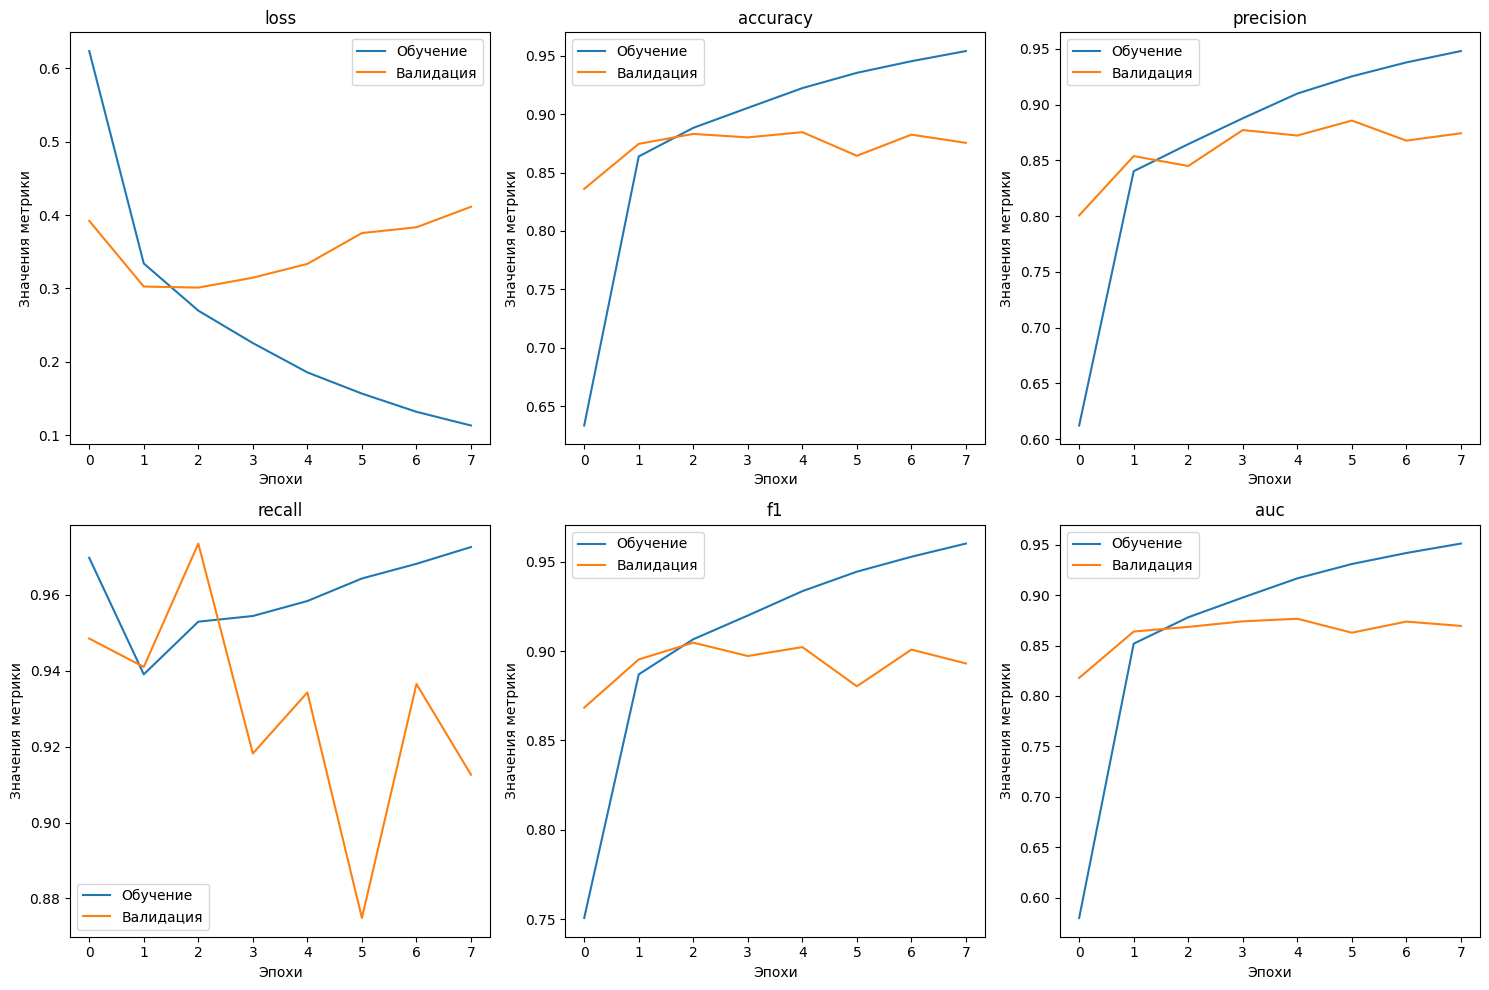

In [63]:
plot_metrics(history, 'GRU')

In [64]:
simple_gru_model.load_state_dict(torch.load('simple_GRU.pth', weights_only=True))

<All keys matched successfully>

## Оценка Simple GRU

In [65]:
loss_eval, metrics_eval, labels_eval, preds_eval = eval_model(simple_gru_model, test_loader, criterion, device)

Evaluating(test): 100%|██████████| 588/588 [00:04<00:00, 129.74it/s]


In [66]:
print(loss_eval),print(metrics_eval)

0.28854084620569026
{'accuracy': 0.8803618946248004, 'precision': 0.8402704243707746, 'recall': 0.9729321890031123, 'F1': 0.9017482517482518, 'AUC': 0.8667030555373445, 'loss': 0.28854084620569026}


(None, None)

In [67]:
labels_eval = np.array(labels_eval, dtype=np.int32)
preds_eval = np.array(preds_eval, dtype=np.int32)

show_metrics(labels_eval, preds_eval, f'Репорт GRU')


                Репорт GRU
 auc: 0.8667030555373445             
 report:                                
              precision    recall  f1-score   support

           0       0.96      0.76      0.85      8187
           1       0.84      0.97      0.90     10603

    accuracy                           0.88     18790
   macro avg       0.90      0.87      0.87     18790
weighted avg       0.89      0.88      0.88     18790


    


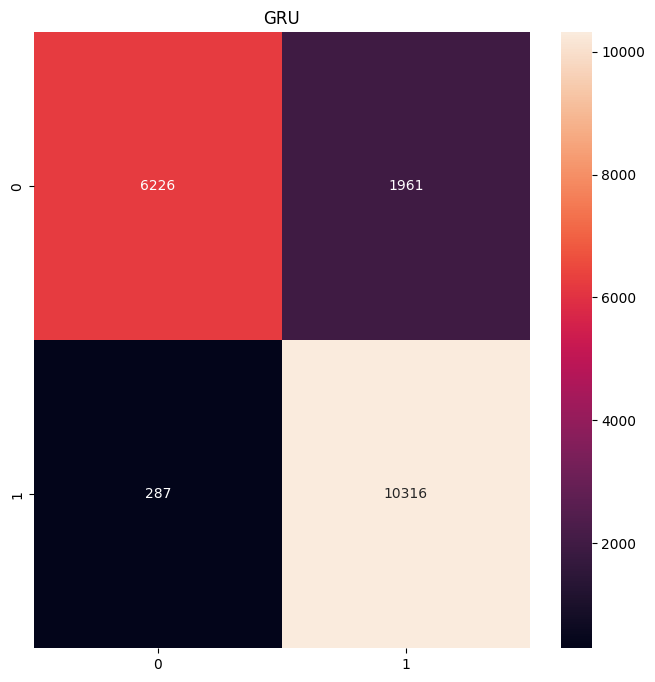

In [68]:
show_confusion_matrix(labels_eval, preds_eval, 'GRU')

In [69]:
# metrics_eval

['accuracy', 'precision', 'recall', 'F1', 'AUC', 'loss']
[0.8804, 0.8403, 0.9729, 0.9017, 0.8667, 0.2885]


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


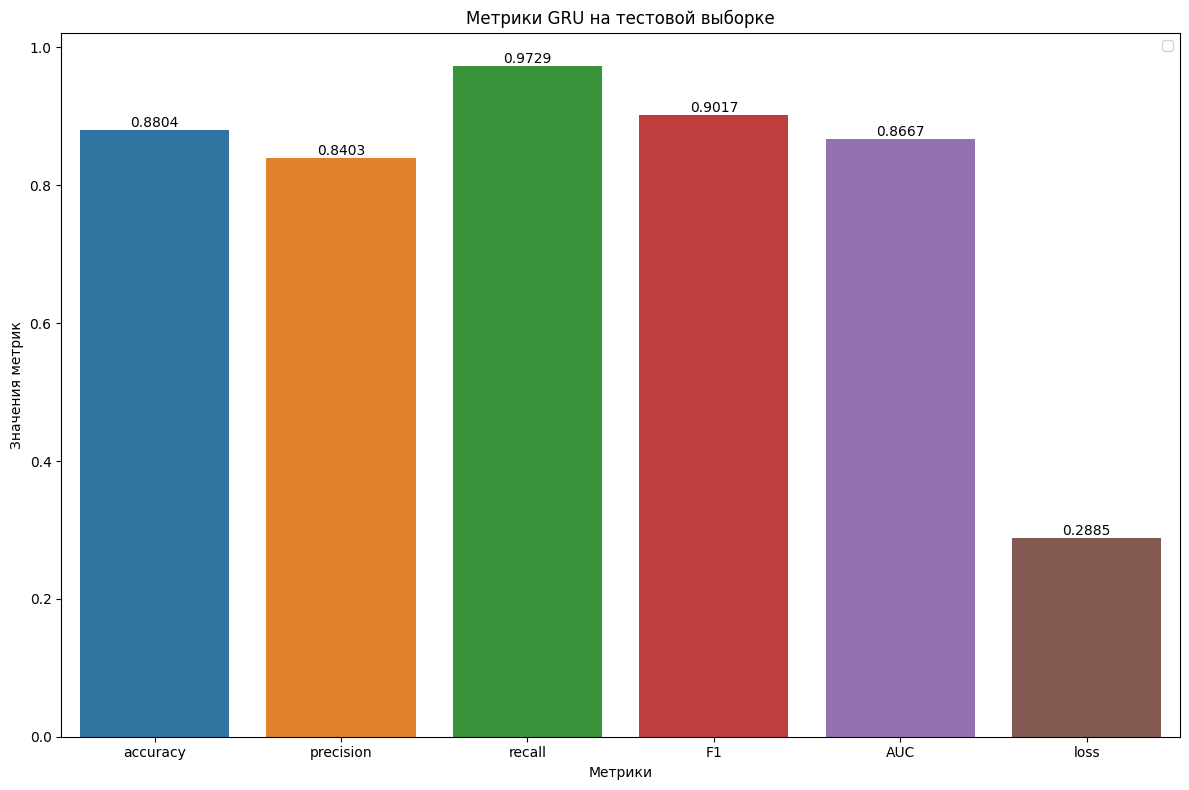

In [70]:
plot_metrics_eval(metrics_eval,'GRU')

# Bidirectional LSTM

In [71]:
class Bid_Lstm_model(nn.Module):
    def __init__(self, vocab_size, embedding_matrix, embedding_dim, hidden_dim, output_dim, dropout_rate, num_layers):
        super(Bid_Lstm_model, self).__init__()
        embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
        # self.embedding.weight.requires_grad = False # заморозка весов для эмбеддинга
        self.embedding_dropout = nn.Dropout(dropout_rate)
        self.lstm = nn.LSTM(
                            input_size=embedding_matrix.shape[1],
                            hidden_size=hidden_dim,
                            batch_first=True,
                            bidirectional=True,
                            num_layers = num_layers,
                            dropout= dropout_rate if num_layers > 1 else 0,
                           )
        self.fc1 = nn.Linear(2*hidden_dim, 128)
        self.batch_norm_1 = nn.BatchNorm1d(128)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(128, 64)
        self.batch_norm_2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(64, output_dim)
        
        
    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.embedding_dropout(embedded)
        lstm_out,_ = self.lstm(embedded)
        # lstm_out = lstm_out[:, -1, :]  # Берем последний таймстеп
        lstm_out = torch.max(lstm_out, dim=1)[0]
        fc1_out = self.fc1(lstm_out)
        fc1_out = self.batch_norm_1(fc1_out)
        fc1_out = self.relu(fc1_out)
        fc1_out = self.dropout1(fc1_out)
        fc2_out = self.fc2(fc1_out)
        fc2_out = self.batch_norm_2(fc2_out)
        fc2_out = self.relu(fc2_out)
        fc2_out = self.dropout2(fc2_out)
        
        output = self.fc3(fc2_out)
        return output
        

In [72]:
# print(simple_lstm_model)

## Обучение

In [73]:
#Гиперпараметры
embedding_dim = 300
hidden_dim = 256
output_dim = 1
lr = 0.005
num_epochs = 100
num_layers = 1
dropout_rate = 0.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [74]:

bid_simple_lstm_model = Bid_Lstm_model(vocab_size=len(vocabulary),
                              embedding_matrix=embedding_matrix, 
                              embedding_dim=embedding_matrix.shape[1],
                              hidden_dim=hidden_dim, 
                              output_dim=output_dim,
                              dropout_rate=dropout_rate,
                              num_layers=num_layers)

In [75]:
init_weights(bid_simple_lstm_model)

In [76]:
print(bid_simple_lstm_model)

Bid_Lstm_model(
  (embedding): Embedding(40085, 300)
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(300, 256, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (batch_norm_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (batch_norm_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


In [77]:
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.AdamW(bid_simple_lstm_model.parameters(), lr=lr, weight_decay=0.0001)
early_stopping = Early_stopping(patience=4, delta=0.001, save_path='bid_lstm_model.pth')

In [78]:
bid_simple_lstm_model.to(device)

Bid_Lstm_model(
  (embedding): Embedding(40085, 300)
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(300, 256, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (batch_norm_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (batch_norm_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

In [79]:
history, grad_logs = train_model(bid_simple_lstm_model,
                      train_loader, 
                      valid_loader, 
                      criterion, 
                      optimizer, 
                      device, 
                      num_epochs,
                      early_stopping = early_stopping  
                     )

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1/100
--------------------
-----Обучение-----


Epochs:   1%|          | 1/100 [00:52<1:26:50, 52.63s/it]

Train Loss: 0.3593 | Train Acc: 0.8469 |  Train Precision: 0.8264 | Train Recall: 0.9251 |  Train F1: 0.8730 | Train AUC: 0.8344
Val Loss: 0.3811 | Val Acc: 0.8361 |  Val Precision: 0.8694 | Val Recall: 0.8383 |  Val F1: 0.8536 | Val AUC: 0.8358
Best loss: 0.3811497986316681

Epoch 2/100
--------------------
-----Обучение-----
Train Loss: 0.3194 | Train Acc: 0.8668 |  Train Precision: 0.8383 | Train Recall: 0.9489 |  Train F1: 0.8902 | Train AUC: 0.8537
Val Loss: 0.3228 | Val Acc: 0.8702 |  Val Precision: 0.8493 | Val Recall: 0.9387 |  Val F1: 0.8918 | Val AUC: 0.8590
Best loss: 0.3228317985409184


Epochs:   2%|▏         | 2/100 [01:45<1:26:10, 52.76s/it]


Epoch 3/100
--------------------
-----Обучение-----
Train Loss: 0.3055 | Train Acc: 0.8724 |  Train Precision: 0.8420 | Train Recall: 0.9548 |  Train F1: 0.8949 | Train AUC: 0.8592
Val Loss: 0.2974 | Val Acc: 0.8755 |  Val Precision: 0.8543 | Val Recall: 0.9421 |  Val F1: 0.8961 | Val AUC: 0.8647
Best loss: 0.2974092772132472


Epochs:   3%|▎         | 3/100 [02:38<1:25:26, 52.85s/it]


Epoch 4/100
--------------------
-----Обучение-----


Epochs:   4%|▍         | 4/100 [03:31<1:24:35, 52.87s/it]

Train Loss: 0.2946 | Train Acc: 0.8762 |  Train Precision: 0.8460 | Train Recall: 0.9564 |  Train F1: 0.8979 | Train AUC: 0.8634
Val Loss: 0.3191 | Val Acc: 0.8672 |  Val Precision: 0.8644 | Val Recall: 0.9096 |  Val F1: 0.8864 | Val AUC: 0.8603

Epoch 5/100
--------------------
-----Обучение-----


Epochs:   5%|▌         | 5/100 [04:24<1:23:39, 52.83s/it]

Train Loss: 0.2860 | Train Acc: 0.8794 |  Train Precision: 0.8500 | Train Recall: 0.9568 |  Train F1: 0.9002 | Train AUC: 0.8670
Val Loss: 0.3067 | Val Acc: 0.8702 |  Val Precision: 0.8587 | Val Recall: 0.9242 |  Val F1: 0.8902 | Val AUC: 0.8614

Epoch 6/100
--------------------
-----Обучение-----
Train Loss: 0.2788 | Train Acc: 0.8828 |  Train Precision: 0.8522 | Train Recall: 0.9605 |  Train F1: 0.9031 | Train AUC: 0.8703
Val Loss: 0.2853 | Val Acc: 0.8799 |  Val Precision: 0.8495 | Val Recall: 0.9593 |  Val F1: 0.9011 | Val AUC: 0.8671
Best loss: 0.28528751119187


Epochs:   6%|▌         | 6/100 [05:17<1:22:52, 52.90s/it]


Epoch 7/100
--------------------
-----Обучение-----


Epochs:   7%|▋         | 7/100 [06:09<1:21:54, 52.85s/it]

Train Loss: 0.2720 | Train Acc: 0.8845 |  Train Precision: 0.8556 | Train Recall: 0.9588 |  Train F1: 0.9043 | Train AUC: 0.8726
Val Loss: 0.2910 | Val Acc: 0.8806 |  Val Precision: 0.8567 | Val Recall: 0.9492 |  Val F1: 0.9006 | Val AUC: 0.8695

Epoch 8/100
--------------------
-----Обучение-----


Epochs:   8%|▊         | 8/100 [07:02<1:21:03, 52.87s/it]

Train Loss: 0.2689 | Train Acc: 0.8864 |  Train Precision: 0.8573 | Train Recall: 0.9601 |  Train F1: 0.9058 | Train AUC: 0.8746
Val Loss: 0.2970 | Val Acc: 0.8812 |  Val Precision: 0.8630 | Val Recall: 0.9410 |  Val F1: 0.9003 | Val AUC: 0.8715

Epoch 9/100
--------------------
-----Обучение-----


Epochs:   9%|▉         | 9/100 [07:55<1:20:06, 52.82s/it]

Train Loss: 0.2630 | Train Acc: 0.8887 |  Train Precision: 0.8599 | Train Recall: 0.9611 |  Train F1: 0.9076 | Train AUC: 0.8772
Val Loss: 0.2943 | Val Acc: 0.8817 |  Val Precision: 0.8594 | Val Recall: 0.9473 |  Val F1: 0.9012 | Val AUC: 0.8710

Epoch 10/100
--------------------
-----Обучение-----


Epochs:   9%|▉         | 9/100 [08:48<1:29:01, 58.70s/it]

Train Loss: 0.2600 | Train Acc: 0.8899 |  Train Precision: 0.8625 | Train Recall: 0.9596 |  Train F1: 0.9084 | Train AUC: 0.8788
Val Loss: 0.3088 | Val Acc: 0.8719 |  Val Precision: 0.8611 | Val Recall: 0.9242 |  Val F1: 0.8915 | Val AUC: 0.8634
Early stopping triggered! Best model weights saved.
Stop after 9 epochs


<ipython-input-20-3aeef0aace76>:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, i + 1)  # 2 строки, 3 столбца, i+1 — позиция графика


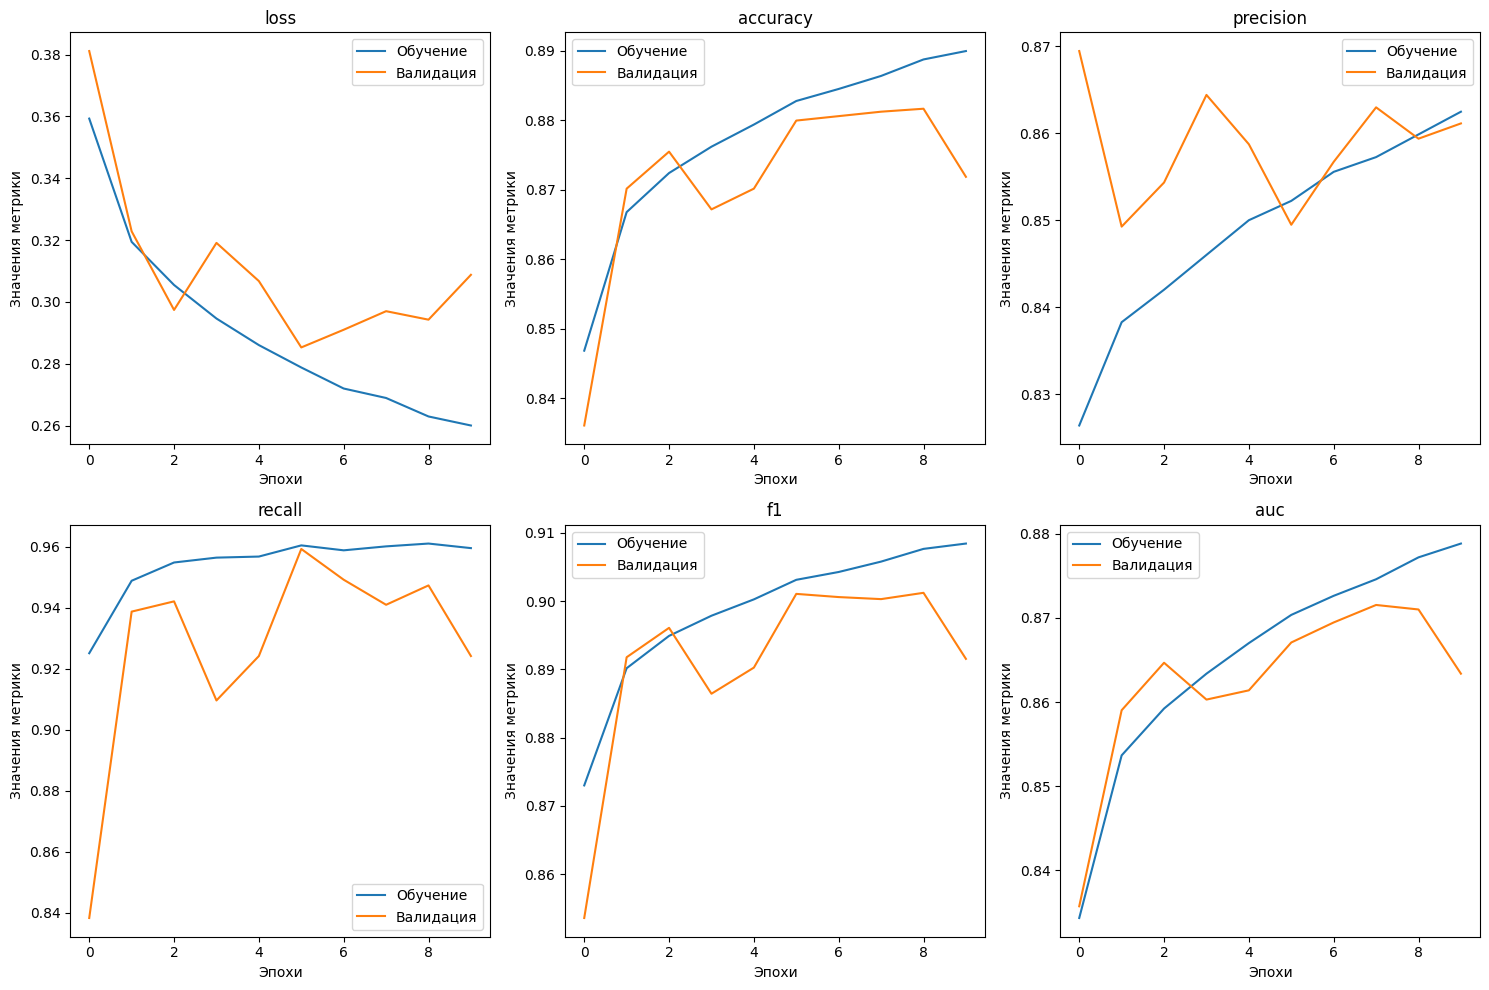

In [80]:
plot_metrics(history, 'Двунаправленная LSTM')

In [81]:
bid_simple_lstm_model.load_state_dict(torch.load('bid_lstm_model.pth', weights_only=True))

<All keys matched successfully>

## Оценка

In [82]:
loss_eval, history_eval, labels, preds = eval_model(bid_simple_lstm_model, test_loader, criterion, device)

Evaluating(test): 100%|██████████| 588/588 [00:06<00:00, 91.07it/s]


In [83]:
show_metrics(labels, preds, 'Двунаправленная LSTM')


                Двунаправленная LSTM
 auc: 0.8718912286106378             
 report:                                
              precision    recall  f1-score   support

         0.0       0.94      0.78      0.85      8187
         1.0       0.85      0.96      0.90     10603

    accuracy                           0.88     18790
   macro avg       0.89      0.87      0.88     18790
weighted avg       0.89      0.88      0.88     18790


    


['accuracy', 'precision', 'recall', 'F1', 'AUC', 'loss']
[0.8831, 0.8524, 0.9589, 0.9025, 0.8719, 0.2786]


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


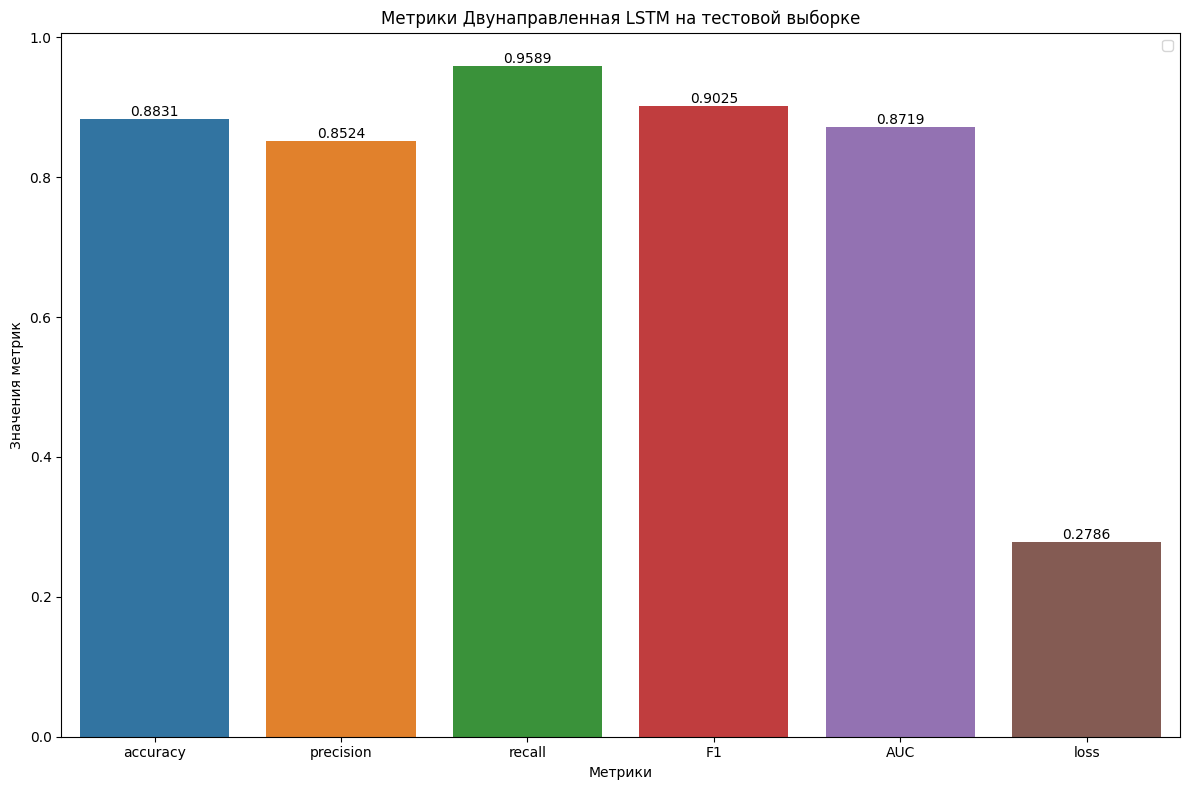

In [84]:
plot_metrics_eval(history_eval, "Двунаправленная LSTM")

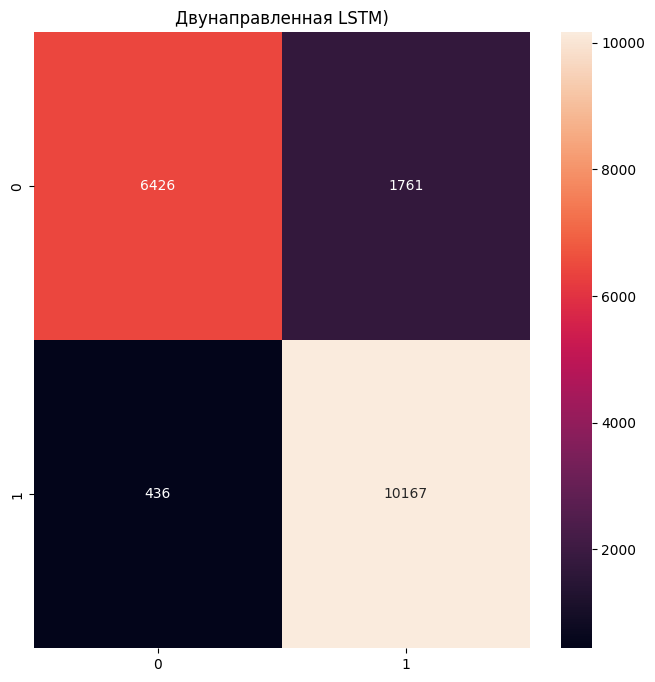

In [85]:
show_confusion_matrix(labels, preds, f'Двунаправленная LSTM)')

# LSTM + CNN

In [86]:
class lstm_cnn(nn.Module):
   def __init__(self, vocab_size, embedding_matrix, embedding_dim, hidden_dim, num_filters, kernel_size, output_dim, dropout_rate, num_layers):
       super(lstm_cnn, self).__init__()
       embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)
       self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
       self.dropout = nn.Dropout(dropout_rate)
       self.lstm = nn.LSTM(input_size=embedding_dim, 
                           hidden_size=hidden_dim, 
                           batch_first=True,
                           bidirectional=True,
                           num_layers=num_layers, 
                           dropout=dropout_rate if num_layers > 1 else 0,
                           )
       # self.ln = nn.LayerNorm(hidden_dim * 2)
       self.conv1 = nn.Conv1d(in_channels = hidden_dim * 2, 
                              out_channels=num_filters, 
                              kernel_size=kernel_size,
                              padding='same')
       self.bn = nn.BatchNorm1d(num_filters)
       self.relu = torch.nn.ReLU()
       
       self.fc1 = nn.Linear(num_filters, output_dim) 
   def forward(self, x):
       embedded = self.dropout(self.embedding(x))
       lstm_out,_ = self.lstm(embedded)
       # lstm_out = self.ln(lstm_out)
       lstm_out = lstm_out.permute(0, 2, 1)
       conv_out = self.conv1(lstm_out)
       conv_out = self.bn(conv_out)
       conv_out = self.relu(conv_out)
       pool = F.max_pool1d(conv_out, conv_out.shape[2]).squeeze(2)
       pool = self.dropout(pool)
       # print("Размер перед fc:", pool.shape)
       out = self.fc1(pool)
       return out

## Обучение LSTM + CNN

In [87]:
# Гиперпараметры
embedding_dim = 300
hidden_dim = 256
num_layers = 1
kernel_size = 3
num_filters = 128
output_dim = 1
lr = 0.001
num_epochs = 100
dropout_rate = 0.25
weight_decay = 0.0001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [88]:
lstm_cnn_model = lstm_cnn(vocab_size=len(vocabulary), 
                          embedding_matrix=embedding_matrix,
                          embedding_dim=embedding_dim,
                          hidden_dim=hidden_dim,
                          num_layers=num_layers,
                          num_filters=num_filters,
                          kernel_size=kernel_size,
                          output_dim=output_dim,
                          dropout_rate=0.25
                         )

In [89]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(lstm_cnn_model.parameters(), lr=lr, weight_decay=weight_decay)
early_stopping = Early_stopping(patience=5, save_path="lstm_cnn.pth")
lstm_cnn_model.to(device)

lstm_cnn(
  (embedding): Embedding(40085, 300)
  (dropout): Dropout(p=0.25, inplace=False)
  (lstm): LSTM(300, 256, batch_first=True, bidirectional=True)
  (conv1): Conv1d(512, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (fc1): Linear(in_features=128, out_features=1, bias=True)
)

In [90]:
print(lstm_cnn_model)

lstm_cnn(
  (embedding): Embedding(40085, 300)
  (dropout): Dropout(p=0.25, inplace=False)
  (lstm): LSTM(300, 256, batch_first=True, bidirectional=True)
  (conv1): Conv1d(512, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (fc1): Linear(in_features=128, out_features=1, bias=True)
)


In [91]:
history, _ = train_model(model=lstm_cnn_model,
            train_loader=train_loader,
            valid_loader=valid_loader,
            criterion=criterion,
            optimizer=optimizer,
            device=device,
            num_epochs=num_epochs,
            early_stopping=early_stopping
           )

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1/100
--------------------
-----Обучение-----


Epochs:   1%|          | 1/100 [01:07<1:51:56, 67.84s/it]

Train Loss: 0.3888 | Train Acc: 0.8352 |  Train Precision: 0.8290 | Train Recall: 0.8950 |  Train F1: 0.8607 | Train AUC: 0.8257
Val Loss: 0.3425 | Val Acc: 0.8553 |  Val Precision: 0.8292 | Val Recall: 0.9395 |  Val F1: 0.8809 | Val AUC: 0.8416
Best loss: 0.3425080070370122

Epoch 2/100
--------------------
-----Обучение-----
Train Loss: 0.3292 | Train Acc: 0.8595 |  Train Precision: 0.8422 | Train Recall: 0.9265 |  Train F1: 0.8824 | Train AUC: 0.8487
Val Loss: 0.3396 | Val Acc: 0.8614 |  Val Precision: 0.8194 | Val Recall: 0.9709 |  Val F1: 0.8887 | Val AUC: 0.8437
Best loss: 0.3395926058292389


Epochs:   2%|▏         | 2/100 [02:14<1:49:55, 67.31s/it]


Epoch 3/100
--------------------
-----Обучение-----
Train Loss: 0.3111 | Train Acc: 0.8684 |  Train Precision: 0.8488 | Train Recall: 0.9353 |  Train F1: 0.8899 | Train AUC: 0.8577
Val Loss: 0.3116 | Val Acc: 0.8691 |  Val Precision: 0.8565 | Val Recall: 0.9253 |  Val F1: 0.8896 | Val AUC: 0.8600
Best loss: 0.3115726521140651


Epochs:   3%|▎         | 3/100 [03:21<1:48:29, 67.11s/it]


Epoch 4/100
--------------------
-----Обучение-----
Train Loss: 0.2960 | Train Acc: 0.8752 |  Train Precision: 0.8532 | Train Recall: 0.9428 |  Train F1: 0.8958 | Train AUC: 0.8644
Val Loss: 0.3066 | Val Acc: 0.8772 |  Val Precision: 0.8449 | Val Recall: 0.9608 |  Val F1: 0.8991 | Val AUC: 0.8636
Best loss: 0.3066293259984569


Epochs:   4%|▍         | 4/100 [04:28<1:47:06, 66.95s/it]


Epoch 5/100
--------------------
-----Обучение-----
Train Loss: 0.2794 | Train Acc: 0.8833 |  Train Precision: 0.8610 | Train Recall: 0.9480 |  Train F1: 0.9024 | Train AUC: 0.8730
Val Loss: 0.2973 | Val Acc: 0.8808 |  Val Precision: 0.8582 | Val Recall: 0.9473 |  Val F1: 0.9006 | Val AUC: 0.8700
Best loss: 0.29732194072321844


Epochs:   5%|▌         | 5/100 [05:35<1:46:00, 66.95s/it]


Epoch 6/100
--------------------
-----Обучение-----


Epochs:   6%|▌         | 6/100 [06:42<1:44:50, 66.92s/it]

Train Loss: 0.2650 | Train Acc: 0.8887 |  Train Precision: 0.8675 | Train Recall: 0.9494 |  Train F1: 0.9066 | Train AUC: 0.8790
Val Loss: 0.3030 | Val Acc: 0.8761 |  Val Precision: 0.8633 | Val Recall: 0.9298 |  Val F1: 0.8953 | Val AUC: 0.8674

Epoch 7/100
--------------------
-----Обучение-----
Train Loss: 0.2504 | Train Acc: 0.8964 |  Train Precision: 0.8759 | Train Recall: 0.9529 |  Train F1: 0.9128 | Train AUC: 0.8874
Val Loss: 0.2967 | Val Acc: 0.8799 |  Val Precision: 0.8506 | Val Recall: 0.9574 |  Val F1: 0.9009 | Val AUC: 0.8674
Best loss: 0.2966576869550504


Epochs:   7%|▋         | 7/100 [07:49<1:43:44, 66.93s/it]


Epoch 8/100
--------------------
-----Обучение-----


Epochs:   8%|▊         | 8/100 [08:55<1:42:33, 66.88s/it]

Train Loss: 0.2307 | Train Acc: 0.9055 |  Train Precision: 0.8877 | Train Recall: 0.9546 |  Train F1: 0.9199 | Train AUC: 0.8976
Val Loss: 0.3055 | Val Acc: 0.8799 |  Val Precision: 0.8622 | Val Recall: 0.9395 |  Val F1: 0.8992 | Val AUC: 0.8703

Epoch 9/100
--------------------
-----Обучение-----


Epochs:   9%|▉         | 9/100 [10:02<1:41:25, 66.87s/it]

Train Loss: 0.2100 | Train Acc: 0.9141 |  Train Precision: 0.8986 | Train Recall: 0.9568 |  Train F1: 0.9268 | Train AUC: 0.9072
Val Loss: 0.3122 | Val Acc: 0.8789 |  Val Precision: 0.8634 | Val Recall: 0.9354 |  Val F1: 0.8980 | Val AUC: 0.8697

Epoch 10/100
--------------------
-----Обучение-----


Epochs:  10%|█         | 10/100 [11:09<1:40:24, 66.94s/it]

Train Loss: 0.1858 | Train Acc: 0.9249 |  Train Precision: 0.9121 | Train Recall: 0.9607 |  Train F1: 0.9357 | Train AUC: 0.9192
Val Loss: 0.3228 | Val Acc: 0.8757 |  Val Precision: 0.8712 | Val Recall: 0.9174 |  Val F1: 0.8937 | Val AUC: 0.8689

Epoch 11/100
--------------------
-----Обучение-----


Epochs:  11%|█         | 11/100 [12:16<1:39:13, 66.89s/it]

Train Loss: 0.1929 | Train Acc: 0.9221 |  Train Precision: 0.9171 | Train Recall: 0.9487 |  Train F1: 0.9327 | Train AUC: 0.9178
Val Loss: 0.3278 | Val Acc: 0.8782 |  Val Precision: 0.8699 | Val Recall: 0.9245 |  Val F1: 0.8964 | Val AUC: 0.8707

Epoch 12/100
--------------------
-----Обучение-----


Epochs:  11%|█         | 11/100 [13:23<1:48:19, 73.03s/it]

Train Loss: 0.1466 | Train Acc: 0.9414 |  Train Precision: 0.9343 | Train Recall: 0.9650 |  Train F1: 0.9494 | Train AUC: 0.9377
Val Loss: 0.3605 | Val Acc: 0.8738 |  Val Precision: 0.8786 | Val Recall: 0.9032 |  Val F1: 0.8908 | Val AUC: 0.8690
Early stopping triggered! Best model weights saved.
Stop after 11 epochs


<ipython-input-20-3aeef0aace76>:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, i + 1)  # 2 строки, 3 столбца, i+1 — позиция графика


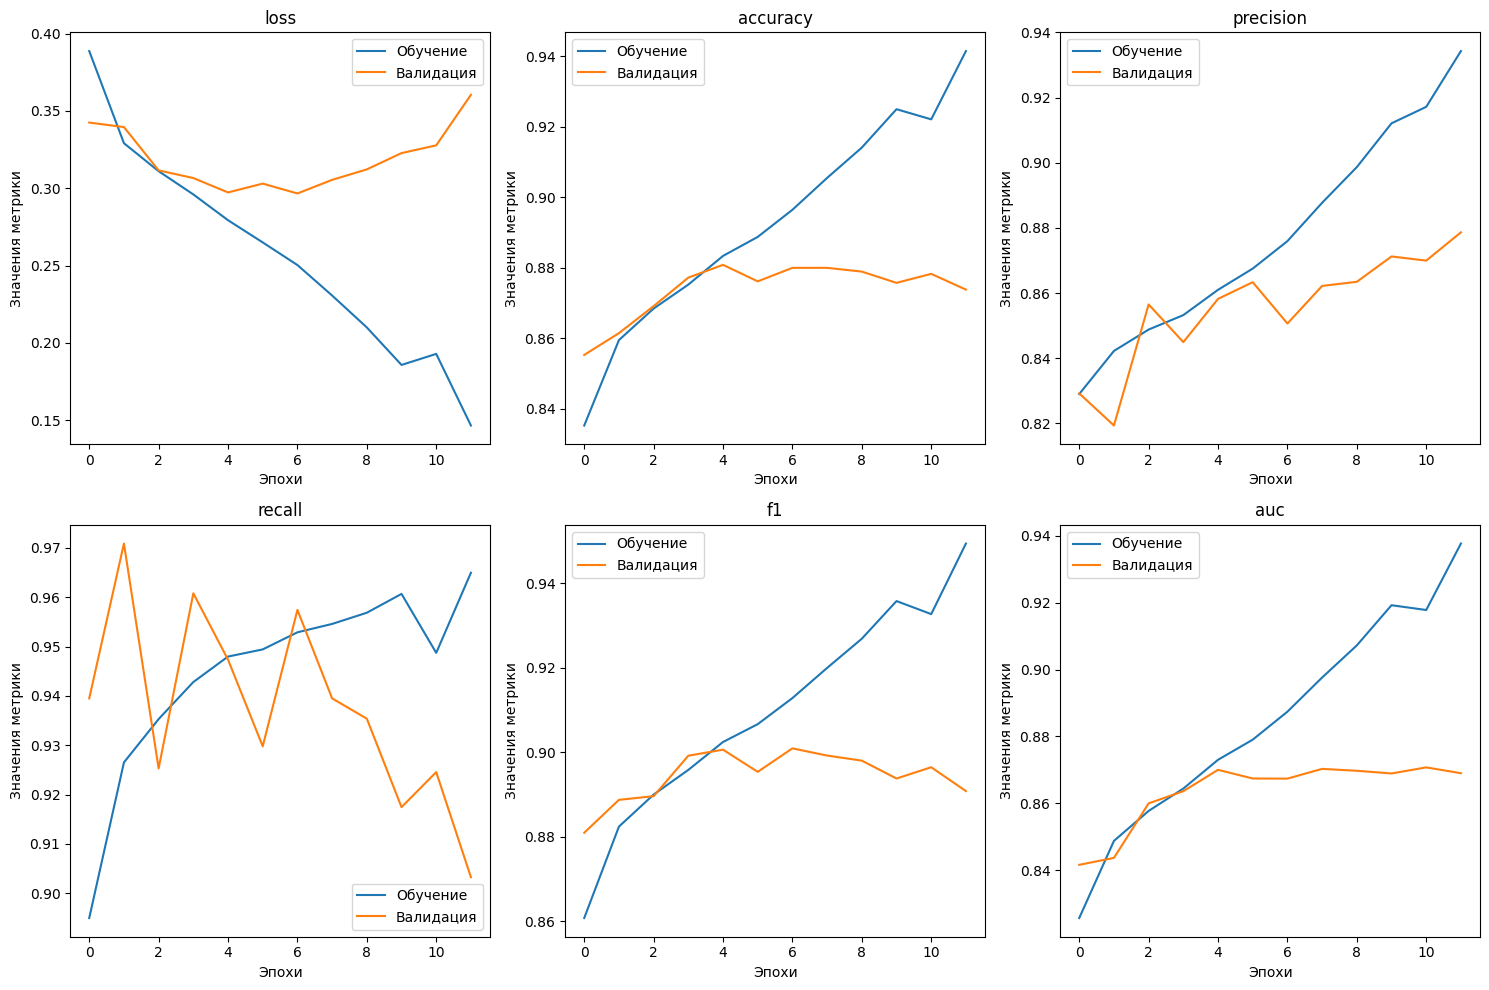

In [92]:
plot_metrics(history, "LSTM + CNN")

In [93]:
lstm_cnn_model.load_state_dict(torch.load('/kaggle/working/lstm_cnn.pth', weights_only=True))

<All keys matched successfully>

## Оценка LSTM + CNN

In [94]:
loss_eval, history_eval, labels, preds = eval_model(lstm_cnn_model, test_loader, criterion, device)

Evaluating(test): 100%|██████████| 588/588 [00:07<00:00, 83.76it/s]


In [95]:
show_metrics(labels, preds, 'Комбинация двунаправленной LSTM и CNN')


                Комбинация двунаправленной LSTM и CNN
 auc: 0.8717149404987015             
 report:                                
              precision    recall  f1-score   support

         0.0       0.94      0.78      0.85      8187
         1.0       0.85      0.96      0.90     10603

    accuracy                           0.88     18790
   macro avg       0.90      0.87      0.88     18790
weighted avg       0.89      0.88      0.88     18790


    


['accuracy', 'precision', 'recall', 'F1', 'AUC', 'loss']
[0.8834, 0.8505, 0.9626, 0.9031, 0.8717, 0.2843]


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


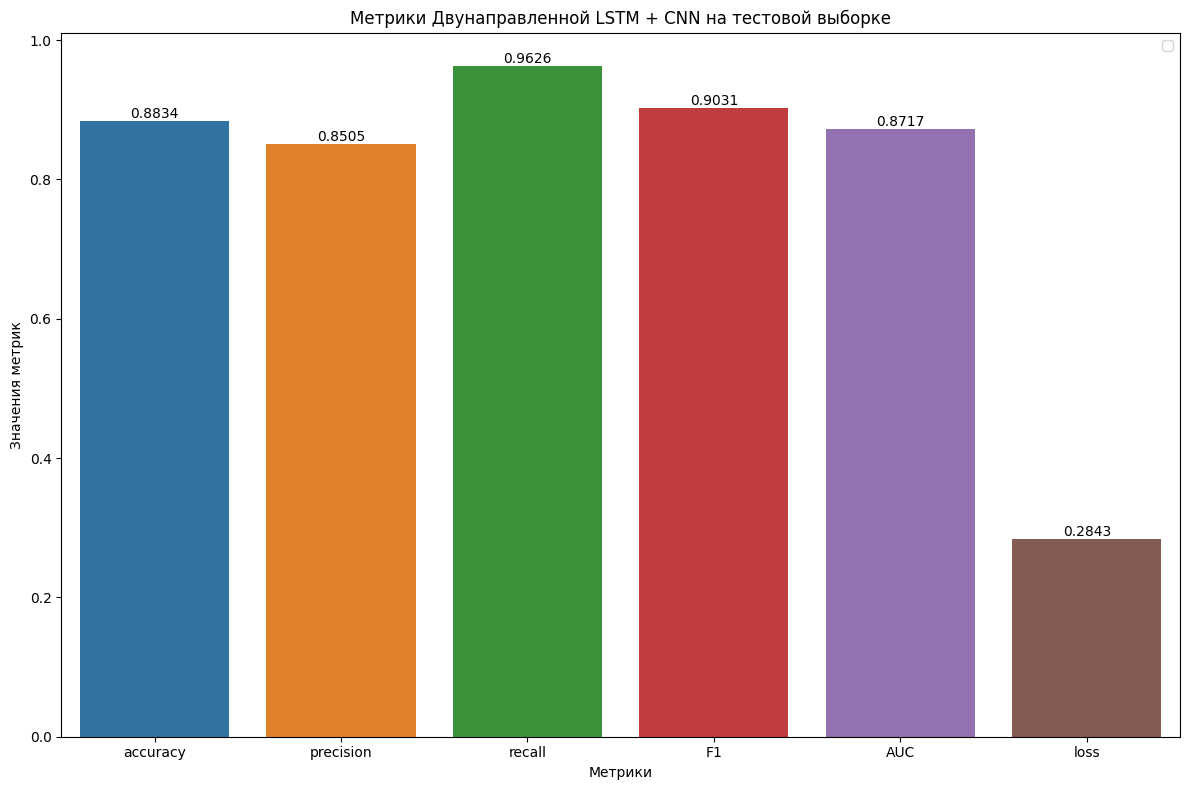

In [96]:
plot_metrics_eval(history_eval, "Двунаправленной LSTM + CNN")

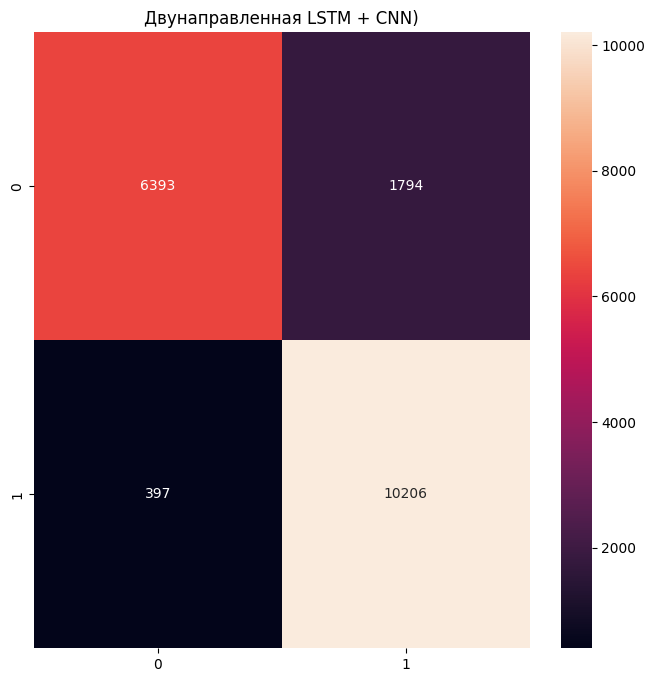

In [97]:
show_confusion_matrix(labels, preds, f'Двунаправленная LSTM + CNN)')

# LSTM + paralel CNN

In [98]:
class lstm_parallel_cnn(nn.Module):
   def __init__(self, vocab_size, embedding_matrix, embedding_dim, hidden_dim, num_filters, kernels_sizes, output_dim, dropout_rate, num_layers):
       super(lstm_parallel_cnn, self).__init__()
       embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)
       self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
       self.dropout = nn.Dropout(dropout_rate)
       self.lstm = nn.LSTM(input_size=embedding_dim, 
                           hidden_size=hidden_dim, 
                           batch_first=True,
                           bidirectional=True,
                           num_layers=num_layers, 
                           dropout=dropout_rate if num_layers > 1 else 0,
                           )
       # self.ln = nn.LayerNorm(hidden_dim * 2)
       
       # Список сверточных слоев
       self.conv_lst = nn.ModuleList([
           nn.Sequential(
               nn.Conv1d(in_channels=hidden_dim*2,out_channels=num_filters,kernel_size=ks),
               nn.BatchNorm1d(num_filters),
               nn.ReLU(),
               nn.Dropout(dropout_rate),
               nn.AdaptiveMaxPool1d(1),
               nn.Flatten()
                        ) for ks in kernels_sizes])
       
       self.bn = nn.BatchNorm1d(num_filters)
       self.relu = torch.nn.ReLU()
       
       self.fc1 = nn.Linear(num_filters*len(kernels_sizes), output_dim) 
   def forward(self, x):
       embedded = self.dropout(self.embedding(x))
       lstm_out,_ = self.lstm(embedded)
       # lstm_out = self.ln(lstm_out)
       lstm_out = lstm_out.permute(0, 2, 1)
       conv_outs = [conv(lstm_out) for conv in self.conv_lst]
       conv_out_cat = torch.cat(conv_outs, dim=1)
       out = self.fc1(conv_out_cat)
       return out

## Обучение LSTM + parallel CNN

In [99]:
lstm_parallel_cnn.__init__

<function __main__.lstm_parallel_cnn.__init__(self, vocab_size, embedding_matrix, embedding_dim, hidden_dim, num_filters, kernels_sizes, output_dim, dropout_rate, num_layers)>

In [100]:
# Гиперпараметры
embedding_dim = 300
hidden_dim = 256
num_layers = 1
kernels_sizes = [2,3,4]
num_filters = 256
output_dim = 1
lr = 0.001
num_epochs = 100
dropout_rate = 0.25
weight_decay = 0.0001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [101]:
lstm_parallel_cnn_model = lstm_parallel_cnn(vocab_size=len(vocabulary), 
                                            embedding_matrix=embedding_matrix,
                                            embedding_dim=embedding_dim,
                                            hidden_dim=hidden_dim,
                                            num_filters=num_filters,
                                            kernels_sizes=kernels_sizes,
                                            output_dim=output_dim,
                                            dropout_rate=dropout_rate,
                                            num_layers=num_layers)
                                            

In [102]:
print(lstm_parallel_cnn_model)

lstm_parallel_cnn(
  (embedding): Embedding(40085, 300)
  (dropout): Dropout(p=0.25, inplace=False)
  (lstm): LSTM(300, 256, batch_first=True, bidirectional=True)
  (conv_lst): ModuleList(
    (0): Sequential(
      (0): Conv1d(512, 256, kernel_size=(2,), stride=(1,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.25, inplace=False)
      (4): AdaptiveMaxPool1d(output_size=1)
      (5): Flatten(start_dim=1, end_dim=-1)
    )
    (1): Sequential(
      (0): Conv1d(512, 256, kernel_size=(3,), stride=(1,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.25, inplace=False)
      (4): AdaptiveMaxPool1d(output_size=1)
      (5): Flatten(start_dim=1, end_dim=-1)
    )
    (2): Sequential(
      (0): Conv1d(512, 256, kernel_size=(4,), stride=(1,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running

In [103]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(lstm_parallel_cnn_model.parameters(), lr=lr, weight_decay=weight_decay)
early_stopping = Early_stopping(patience=5, save_path="lstm_parallel_cnn.pth")
lstm_parallel_cnn_model.to(device)

lstm_parallel_cnn(
  (embedding): Embedding(40085, 300)
  (dropout): Dropout(p=0.25, inplace=False)
  (lstm): LSTM(300, 256, batch_first=True, bidirectional=True)
  (conv_lst): ModuleList(
    (0): Sequential(
      (0): Conv1d(512, 256, kernel_size=(2,), stride=(1,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.25, inplace=False)
      (4): AdaptiveMaxPool1d(output_size=1)
      (5): Flatten(start_dim=1, end_dim=-1)
    )
    (1): Sequential(
      (0): Conv1d(512, 256, kernel_size=(3,), stride=(1,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.25, inplace=False)
      (4): AdaptiveMaxPool1d(output_size=1)
      (5): Flatten(start_dim=1, end_dim=-1)
    )
    (2): Sequential(
      (0): Conv1d(512, 256, kernel_size=(4,), stride=(1,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running

In [104]:
history, _ = train_model(model=lstm_parallel_cnn_model,
            train_loader=train_loader,
            valid_loader=valid_loader,
            criterion=criterion,
            optimizer=optimizer,
            device=device,
            num_epochs=num_epochs,
            early_stopping=early_stopping
           )

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1/100
--------------------
-----Обучение-----


Epochs:   1%|          | 1/100 [01:48<2:58:21, 108.09s/it]

Train Loss: 0.4192 | Train Acc: 0.8292 |  Train Precision: 0.8298 | Train Recall: 0.8803 |  Train F1: 0.8543 | Train AUC: 0.8210
Val Loss: 0.3301 | Val Acc: 0.8650 |  Val Precision: 0.8413 | Val Recall: 0.9406 |  Val F1: 0.8882 | Val AUC: 0.8528
Best loss: 0.3301029707256116

Epoch 2/100
--------------------
-----Обучение-----
Train Loss: 0.3308 | Train Acc: 0.8608 |  Train Precision: 0.8466 | Train Recall: 0.9225 |  Train F1: 0.8829 | Train AUC: 0.8509
Val Loss: 0.3271 | Val Acc: 0.8693 |  Val Precision: 0.8341 | Val Recall: 0.9619 |  Val F1: 0.8935 | Val AUC: 0.8543
Best loss: 0.327080510164562


Epochs:   2%|▏         | 2/100 [03:36<2:57:04, 108.41s/it]


Epoch 3/100
--------------------
-----Обучение-----
Train Loss: 0.3116 | Train Acc: 0.8687 |  Train Precision: 0.8538 | Train Recall: 0.9281 |  Train F1: 0.8894 | Train AUC: 0.8592
Val Loss: 0.3150 | Val Acc: 0.8725 |  Val Precision: 0.8484 | Val Recall: 0.9451 |  Val F1: 0.8942 | Val AUC: 0.8607
Best loss: 0.31498376789845917


Epochs:   3%|▎         | 3/100 [05:24<2:54:56, 108.21s/it]


Epoch 4/100
--------------------
-----Обучение-----
Train Loss: 0.2936 | Train Acc: 0.8759 |  Train Precision: 0.8610 | Train Recall: 0.9325 |  Train F1: 0.8953 | Train AUC: 0.8669
Val Loss: 0.3097 | Val Acc: 0.8655 |  Val Precision: 0.8706 | Val Recall: 0.8973 |  Val F1: 0.8837 | Val AUC: 0.8603
Best loss: 0.3097208895181355


Epochs:   4%|▍         | 4/100 [07:12<2:53:07, 108.20s/it]


Epoch 5/100
--------------------
-----Обучение-----
Train Loss: 0.2793 | Train Acc: 0.8825 |  Train Precision: 0.8689 | Train Recall: 0.9344 |  Train F1: 0.9004 | Train AUC: 0.8741
Val Loss: 0.3080 | Val Acc: 0.8759 |  Val Precision: 0.8710 | Val Recall: 0.9182 |  Val F1: 0.8940 | Val AUC: 0.8690
Best loss: 0.3079505735322049


Epochs:   5%|▌         | 5/100 [09:01<2:51:18, 108.20s/it]


Epoch 6/100
--------------------
-----Обучение-----


Epochs:   6%|▌         | 6/100 [10:49<2:49:25, 108.14s/it]

Train Loss: 0.2607 | Train Acc: 0.8907 |  Train Precision: 0.8762 | Train Recall: 0.9409 |  Train F1: 0.9074 | Train AUC: 0.8827
Val Loss: 0.3127 | Val Acc: 0.8695 |  Val Precision: 0.8694 | Val Recall: 0.9074 |  Val F1: 0.8880 | Val AUC: 0.8634

Epoch 7/100
--------------------
-----Обучение-----


Epochs:   7%|▋         | 7/100 [12:37<2:47:31, 108.08s/it]

Train Loss: 0.2418 | Train Acc: 0.8996 |  Train Precision: 0.8881 | Train Recall: 0.9422 |  Train F1: 0.9144 | Train AUC: 0.8928
Val Loss: 0.3115 | Val Acc: 0.8640 |  Val Precision: 0.8777 | Val Recall: 0.8846 |  Val F1: 0.8811 | Val AUC: 0.8606

Epoch 8/100
--------------------
-----Обучение-----
Train Loss: 0.2193 | Train Acc: 0.9089 |  Train Precision: 0.9022 | Train Recall: 0.9420 |  Train F1: 0.9217 | Train AUC: 0.9036
Val Loss: 0.2962 | Val Acc: 0.8806 |  Val Precision: 0.8651 | Val Recall: 0.9365 |  Val F1: 0.8994 | Val AUC: 0.8715
Best loss: 0.2962122685030887


Epochs:   8%|▊         | 8/100 [14:25<2:45:41, 108.06s/it]


Epoch 9/100
--------------------
-----Обучение-----


Epochs:   9%|▉         | 9/100 [16:12<2:43:43, 107.95s/it]

Train Loss: 0.1876 | Train Acc: 0.9229 |  Train Precision: 0.9157 | Train Recall: 0.9521 |  Train F1: 0.9335 | Train AUC: 0.9182
Val Loss: 0.3069 | Val Acc: 0.8759 |  Val Precision: 0.8610 | Val Recall: 0.9328 |  Val F1: 0.8955 | Val AUC: 0.8667

Epoch 10/100
--------------------
-----Обучение-----


Epochs:  10%|█         | 10/100 [18:00<2:41:51, 107.91s/it]

Train Loss: 0.1567 | Train Acc: 0.9357 |  Train Precision: 0.9312 | Train Recall: 0.9577 |  Train F1: 0.9443 | Train AUC: 0.9322
Val Loss: 0.3260 | Val Acc: 0.8819 |  Val Precision: 0.8624 | Val Recall: 0.9432 |  Val F1: 0.9010 | Val AUC: 0.8719

Epoch 11/100
--------------------
-----Обучение-----


Epochs:  11%|█         | 11/100 [19:48<2:40:12, 108.00s/it]

Train Loss: 0.1265 | Train Acc: 0.9497 |  Train Precision: 0.9470 | Train Recall: 0.9656 |  Train F1: 0.9562 | Train AUC: 0.9472
Val Loss: 0.3433 | Val Acc: 0.8799 |  Val Precision: 0.8670 | Val Recall: 0.9324 |  Val F1: 0.8985 | Val AUC: 0.8714

Epoch 12/100
--------------------
-----Обучение-----


Epochs:  12%|█▏        | 12/100 [21:36<2:38:23, 108.00s/it]

Train Loss: 0.1031 | Train Acc: 0.9596 |  Train Precision: 0.9579 | Train Recall: 0.9717 |  Train F1: 0.9647 | Train AUC: 0.9577
Val Loss: 0.3787 | Val Acc: 0.8857 |  Val Precision: 0.8662 | Val Recall: 0.9455 |  Val F1: 0.9041 | Val AUC: 0.8760

Epoch 13/100
--------------------
-----Обучение-----


Epochs:  12%|█▏        | 12/100 [23:24<2:51:42, 117.07s/it]

Train Loss: 0.0851 | Train Acc: 0.9663 |  Train Precision: 0.9665 | Train Recall: 0.9745 |  Train F1: 0.9705 | Train AUC: 0.9650
Val Loss: 0.3930 | Val Acc: 0.8657 |  Val Precision: 0.8720 | Val Recall: 0.8958 |  Val F1: 0.8837 | Val AUC: 0.8608
Early stopping triggered! Best model weights saved.
Stop after 12 epochs


<ipython-input-20-3aeef0aace76>:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, i + 1)  # 2 строки, 3 столбца, i+1 — позиция графика


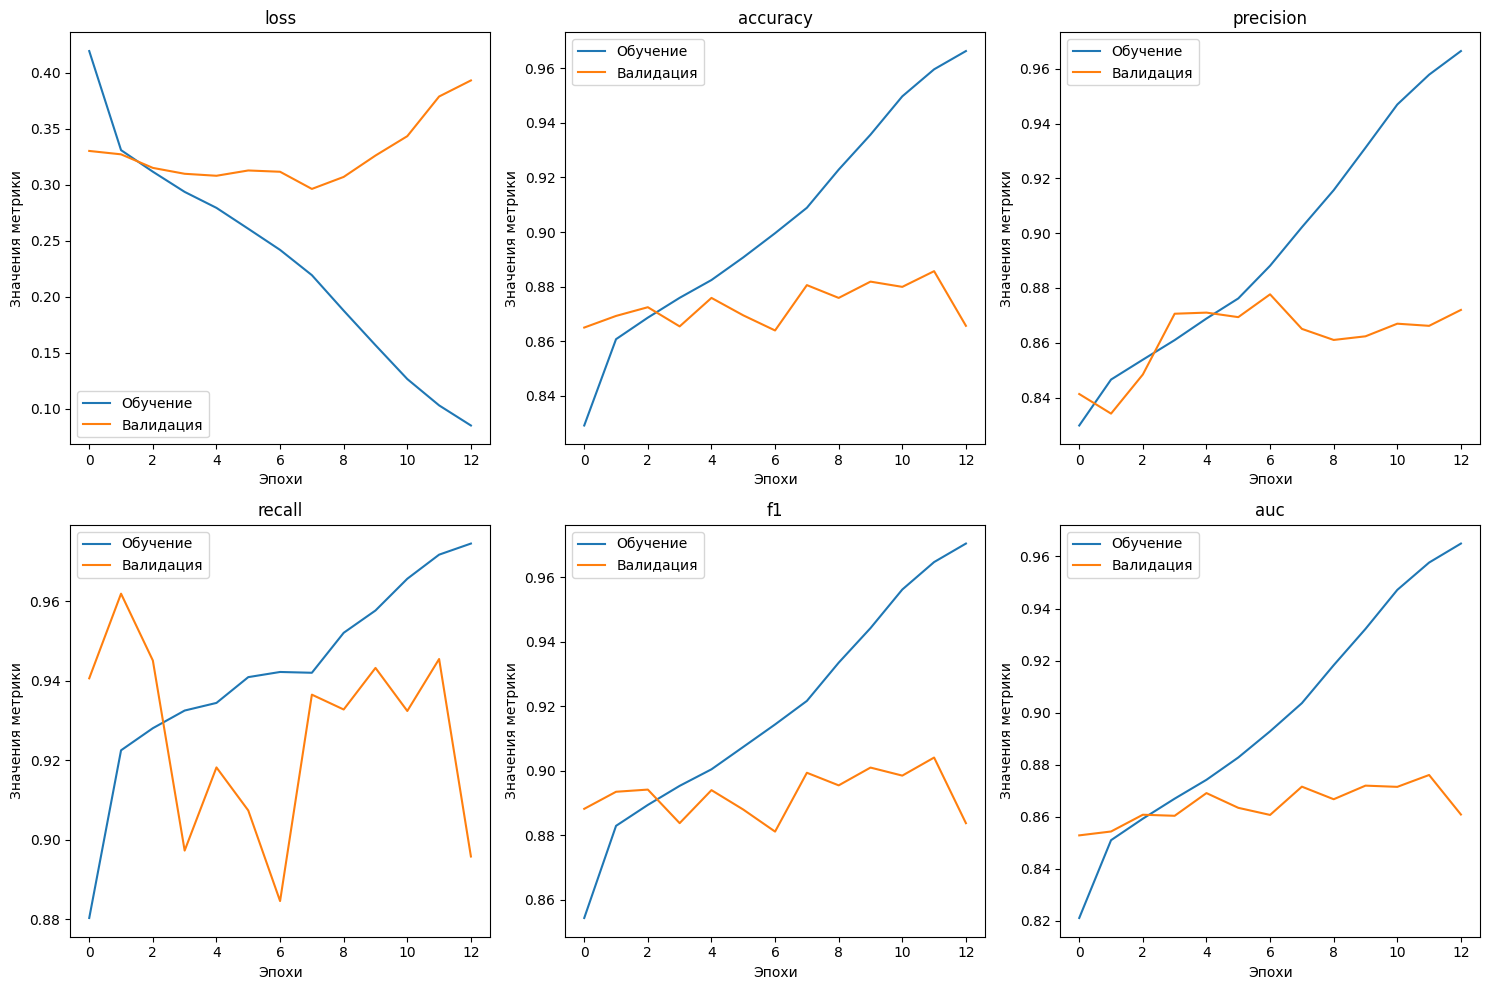

In [105]:
plot_metrics(history, "LSTM + параллельная CNN")

In [106]:
lstm_parallel_cnn_model.load_state_dict(torch.load('lstm_parallel_cnn.pth', weights_only=True))

<All keys matched successfully>

## Оценка LSTM + parallel CNN

In [107]:
loss_eval, history_eval, labels, preds = eval_model(lstm_parallel_cnn_model, test_loader, criterion, device)

Evaluating(test): 100%|██████████| 588/588 [00:10<00:00, 56.69it/s]


In [108]:
show_metrics(labels, preds, 'Двунаправленная LSTM + параллельный CNN')



                Двунаправленная LSTM + параллельный CNN
 auc: 0.8754026716882111             
 report:                                
              precision    recall  f1-score   support

         0.0       0.91      0.81      0.86      8187
         1.0       0.87      0.94      0.90     10603

    accuracy                           0.88     18790
   macro avg       0.89      0.88      0.88     18790
weighted avg       0.89      0.88      0.88     18790


    


['accuracy', 'precision', 'recall', 'F1', 'AUC', 'loss']
[0.8834, 0.8667, 0.9376, 0.9007, 0.8754, 0.2844]


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


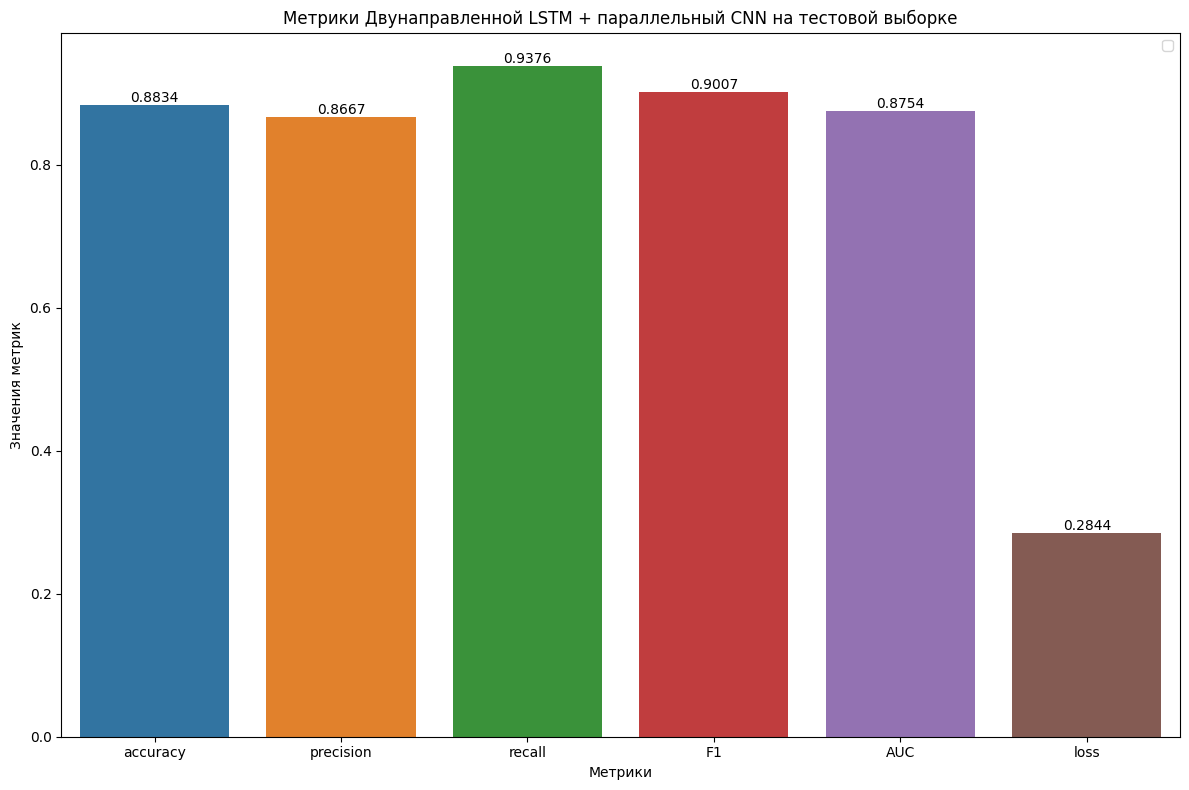

In [109]:
plot_metrics_eval(history_eval, "Двунаправленной LSTM + параллельный CNN")

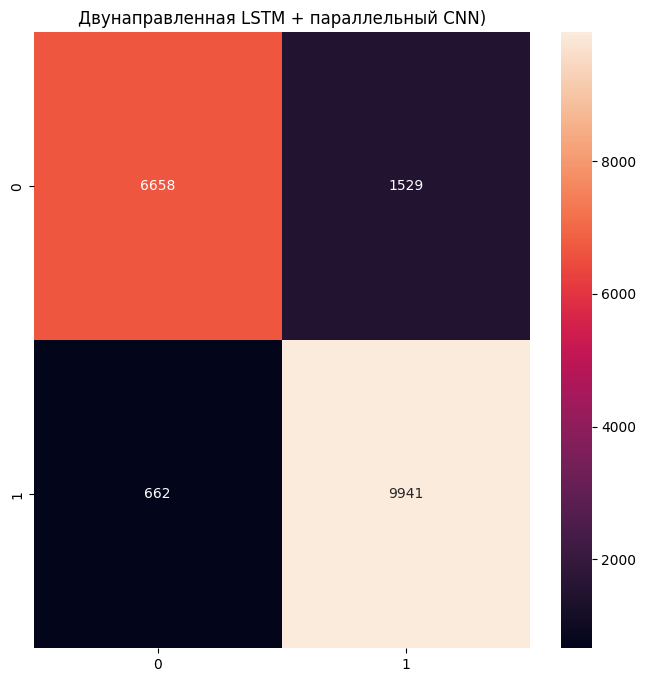

In [110]:
show_confusion_matrix(labels, preds, f'Двунаправленная LSTM + параллельный CNN)')